In [60]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import scipy.stats as stats
import pandas as pd
import os
import pingouin as pg
import warnings
import json
from astropy.stats import rayleightest
from astropy import units as u
warnings.filterwarnings('ignore')
# set the backend of matplotlib to an interactive one
plt.ion()

In [3]:
def circular_distance(x, y):
    d = y - x
    if isinstance(d, (int, float)):
        if d >= 180:
            return d - 360
        if d < -180:
            return d + 360
        return d
    d[d >= 180] -= 360
    d[d < -180] += 360
    return d

In [4]:
# Add MemoryType and CueCondition columns based on shapeTruth and available cue information
def classify_memory_and_cue(row, wm_values, ltm_values):
    try:
        shape_truth_value = int(row['shapeTruth'])
    except ValueError:
        # If conversion fails, default to a placeholder that won't match WM or LTM values
        shape_truth_value = -1
    # Determine if the item is WM or LTM based on shapeTruth
    memory_type = 'WM' if shape_truth_value in wm_values else 'LTM' if shape_truth_value in ltm_values else 'Unknown'
    cue_condition = 'Neutral' if row['cueLoc'] == 'neutral' else 'Informative' if row['cueLoc'] in ['wm1', 'wm2', 'ltm1', 'ltm2'] else 'Unknown'
    return pd.Series([memory_type, cue_condition], index=['MemoryType', 'CueCondition'])

In [5]:
# data directory
data_dir = '../data/day2'
# find all csv files in the data directory
all_files = os.listdir(data_dir)
# filter out the csv files
participant_files = [f for f in all_files if f.endswith('.csv')]
# Path to all participant files
participant_files = [data_dir + '/' + f for f in participant_files]
# Constants
WM_LTM_VALUES = [89, 179, 269, 359]
color_wm = np.array([65, 143, 111]) / 255
color_ltm = np.array([138, 118, 190]) / 255


In [6]:
participant_ids = []
for file_path in participant_files:
    # Extract participant ID
    participant_id = file_path.split('_')[0].split('/')[-1]
    # save the participant ID to the list
    participant_ids.append(participant_id)

participant_files = [f for f in participant_files if f.split('_')[0].split('/')[-1] in participant_ids]

In [7]:

def process_participant_data(file_path,participant_id):
    data = pd.read_csv(file_path)
    ltm_values = data[['trueMemory1', 'trueMemory2']].dropna().astype(int).values.flatten().tolist()
    wm_values = [value for value in WM_LTM_VALUES if value not in ltm_values]
    test_trial_start_index = data['PracBlockEnd.stopped'].first_valid_index() + 1
    test_trials = data.iloc[test_trial_start_index:]
    test_trials['ParticipantID'] = participant_id  # Add participant identifier
    memory_trials = test_trials[test_trials['taskType'] == 'memory']
    memory_trials['ltm_shapes'] = [ltm_values for _ in range(len(memory_trials))]
    memory_trials['wm_shapes'] = [wm_values for _ in range(len(memory_trials))]
    memory_trials[['MemoryType', 'CueCondition']] = memory_trials.apply(
        lambda row: classify_memory_and_cue(row, wm_values,ltm_values), axis=1)

    return memory_trials[['ParticipantID', 'mouseTime', 'shapeTruth', 'selectedShape', 'deviation', 'rawDeviation', 'MemoryType', 'CueCondition', 'ltm_shapes', 'wm_shapes']]

# Process data for all participants with participant identifiers
# participant_ids = [f"Participant_{i+1}" for i in range(len(participant_files))]
data_list = []
for path,pid in zip(participant_files,participant_ids):
    tmp = process_participant_data(path,pid)
    data_list.append(tmp)

all_participants_data = pd.concat(data_list,ignore_index=True)

# Identify and exclude outlier trials where the rection time is over 3 SD criterion larger or smaller than the mean. Calculate the mean and standard deviation of the reaction time for each participant. 
all_participants_data['mouseTime'] = all_participants_data['mouseTime'].astype(float)
for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    mean_time = participant_data['mouseTime'].mean()
    std_time = participant_data['mouseTime'].std()
    participant_data['outlier'] = (participant_data['mouseTime'] < mean_time - 3 * std_time) | (participant_data['mouseTime'] > mean_time + 3 * std_time)
    all_participants_data.loc[all_participants_data['ParticipantID'] == pid, 'outlier'] = participant_data['outlier']
# Caluclate the rate of outlier trials for each participant
outlier_rates = all_participants_data.groupby('ParticipantID')['outlier'].mean()
# Calculate the average rate and standard deviation of outlier trials across all participants
mean_outlier_rate = outlier_rates.mean()
std_outlier_rate = outlier_rates.std()
print(f'Mean outlier rate: {mean_outlier_rate:.3f} ± {std_outlier_rate:.3f}')

# Calculate the overall rate of outlier trials
outlier_trials = all_participants_data[all_participants_data['outlier'] == True]
outlier_trials_count = outlier_trials.shape[0]
outlier_trials_rate = outlier_trials_count / all_participants_data.shape[0]
print(f'Rate of outlier trials: {outlier_trials_rate:.3f}')

memory_task_data = all_participants_data

# Exclude outlier trials
all_participants_data = all_participants_data[all_participants_data['outlier'] == False]

Mean outlier rate: 0.011 ± 0.009
Rate of outlier trials: 0.012


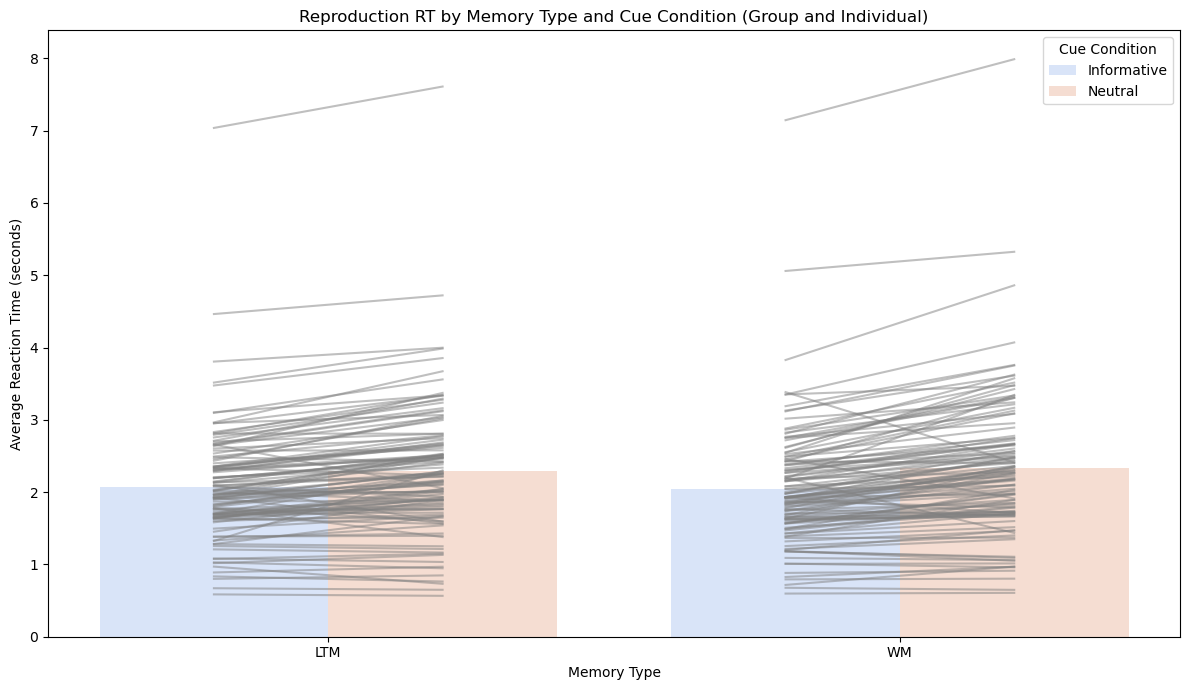

In [8]:

# Group data by MemoryType and CueCondition for RT analysis
grouped_data = all_participants_data.groupby(['MemoryType', 'CueCondition'])['mouseTime'].mean().reset_index()

# Calculate within-participant averages for RT, considering both MemoryType and CueCondition
within_participant_averages = all_participants_data.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['mouseTime'].mean().reset_index()

# Calculate group-level averages for RT, considering both MemoryType and CueCondition
group_level_averages = within_participant_averages.groupby(['MemoryType', 'CueCondition'])['mouseTime'].mean().reset_index()

# Plotting with cue conditions
plt.figure(figsize=(12, 7))
sns.barplot(x='MemoryType', y='mouseTime', hue='CueCondition', data=group_level_averages, palette='coolwarm', errorbar=None, alpha=0.5)
# Add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    informative_data = participant_data[participant_data['CueCondition'] == 'Informative']
    neutral_data = participant_data[participant_data['CueCondition'] == 'Neutral']
    for participant in participant_ids:
        informative_rt = informative_data[informative_data['ParticipantID'] == participant]['mouseTime'].values
        neutral_rt = neutral_data[neutral_data['ParticipantID'] == participant]['mouseTime'].values
        # adjust the x position of the lines
        x_position = 1 if memory_type == 'WM' else 0
        plt.plot([x_position-0.2, x_position+0.2], [informative_rt, neutral_rt], color='grey', alpha=0.5)
        # add a label for the participant
        # if participant == 'Participant_12':
        #     plt.text(x_position-0.5, informative_rt, participant, fontsize=8, color='grey')
# sns.stripplot(x='MemoryType', y='mouseTime', data=within_participant_averages, hue='CueCondition', dodge=True, palette='coolwarm', marker='o', size=8, alpha=1)

plt.title('Reproduction RT by Memory Type and Cue Condition (Group and Individual)')
plt.xlabel('Memory Type')
plt.ylabel('Average Reaction Time (seconds)')
plt.legend(title='Cue Condition')
plt.tight_layout()
plt.show()



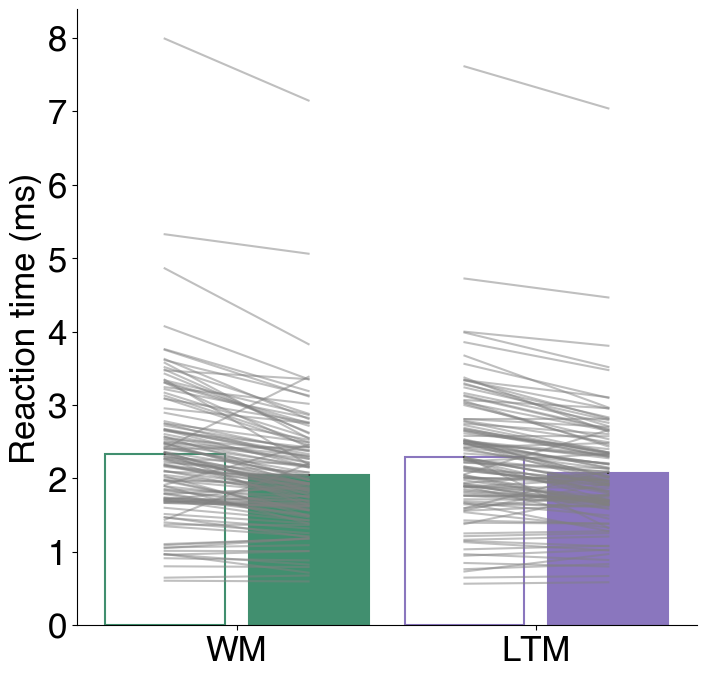

In [9]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
informative_means = group_level_averages[group_level_averages['CueCondition'] == 'Informative']['mouseTime']
# reorder the informative_means so that WM is plotted first
informative_means = informative_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'Neutral']['mouseTime']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, informative_means, width, label='Informative', color=[color_wm, color_ltm], edgecolor= [color_wm, color_ltm], linewidth=1.5, linestyle='-')
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
rt_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='mouseTime')
# Calculate grand mean, subject means, and normalized data
grand_mean = rt_data.mean().mean()
subject_means = rt_data.mean(axis=1)
normalized_data = rt_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(rt_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
informative_se = corrected_se[:2]
# reorder the informative_se so that WM is plotted first
informative_se = informative_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]
# Add error bars
ax.errorbar(x + width*0.6, informative_means, yerr=informative_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)

# add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    informative_data = participant_data[participant_data['CueCondition'] == 'Informative']
    neutral_data = participant_data[participant_data['CueCondition'] == 'Neutral']
    for participant in participant_ids:
        informative_deviation = informative_data[informative_data['ParticipantID'] == participant]['mouseTime'].values
        neutral_deviation = neutral_data[neutral_data['ParticipantID'] == participant]['mouseTime'].values
        # adjust the x position of the lines
        x_position = 0 if memory_type == 'WM' else 1
        plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_deviation,informative_deviation], color='grey', alpha=0.5)
        
ax.set_ylabel('Reaction time (ms)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(0, None)
# ax.set_title('Reproduction RTs by Memory Type and Cue Condition')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)
    
plt.show()

In [10]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages, depvar='mouseTime', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
# print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages, dv='mouseTime', within=['MemoryType', 'CueCondition'], subject='ParticipantID',effsize="np2")


Source        SS  ddof1  ddof2        MS           F  \
0                 MemoryType  0.014319      1    118  0.014319    0.271328   
1               CueCondition  7.517035      1    118  7.517035  113.286674   
2  MemoryType * CueCondition  0.169759      1    118  0.169759   12.643272   

          p-unc     p-GG-corr       np2  eps  
0  6.034183e-01  6.034183e-01  0.002294  1.0  
1  5.922767e-19  5.922767e-19  0.489811  1.0  
2  5.434381e-04  5.434381e-04  0.096777  1.0

In [11]:

# perform a paired-samples (informative vs neutral) t-test for WM and LTM separately
# WM
# Informative cue
informative_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'Informative')]['mouseTime']
# Neutral cue
neutral_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'Neutral')]['mouseTime']
# Perform the t-test
pg.ttest(informative_wm, neutral_wm, paired=True)


T  dof alternative         p-val           CI95%   cohen-d  \
T-test -10.080192  118   two-sided  1.293784e-17  [-0.35, -0.23]  0.318225   

             BF10     power  
T-test  4.346e+14  0.930973

In [12]:

t, p = stats.ttest_rel(informative_wm, neutral_wm)
print('t = %f, p = %f' % (t, p))


t = -10.080192, p = 0.000000


In [13]:

# LTM
# Informative cue
informative_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'Informative')]['mouseTime']
# Neutral cue
neutral_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'Neutral')]['mouseTime']
# Perform the t-test
pg.ttest(informative_ltm, neutral_ltm, paired=True)



T  dof alternative         p-val           CI95%  cohen-d  \
T-test -9.380751  118   two-sided  5.862839e-16  [-0.26, -0.17]  0.25268   

             BF10     power  
T-test  1.054e+13  0.780522

In [14]:
pg.ttest(neutral_wm, neutral_ltm, paired=True)

T  dof alternative     p-val        CI95%  cohen-d   BF10  \
T-test  1.923721  118   two-sided  0.056798  [-0.0, 0.1]  0.05174  0.604   

           power  
T-test  0.086608

In [15]:
# subtract informative from neutral for both WM and LTM, and do a paired t-test
# Subtract neutral from informative (need to transform neutral and informative from Series to numpy array)
diff_wm = informative_wm.values - neutral_wm.values
diff_ltm = informative_ltm.values - neutral_ltm.values
# Perform the t-test
pg.ttest(diff_wm, diff_ltm, paired=True)

T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.555738  118   two-sided  0.000543  [-0.12, -0.03]  0.267438  36.215   

           power  
T-test  0.824751

In [16]:
all_participants_data['MemoryType'].value_counts()

MemoryType
LTM    14025
WM     13989
Name: count, dtype: int64

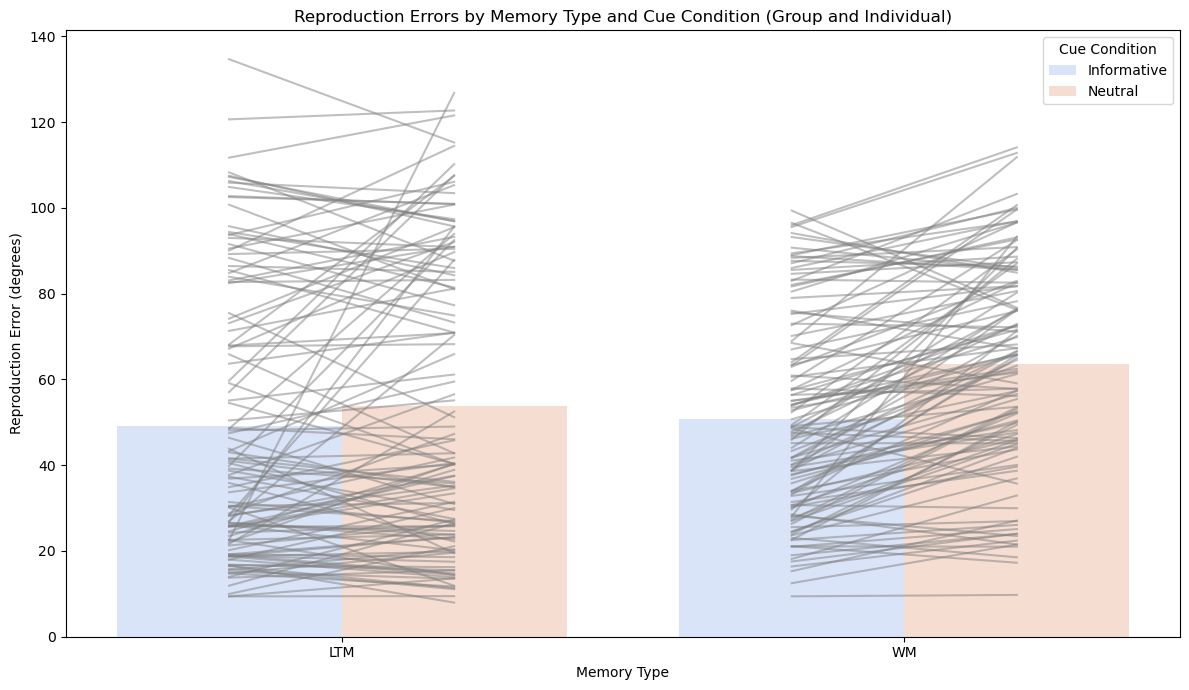

In [17]:
# Group data by MemoryType and CueCondition for deviation analysis
# change the type of deviation to float
all_participants_data['deviation'] = all_participants_data['deviation'].astype(float)
grouped_data = all_participants_data.groupby(['MemoryType', 'CueCondition'])['deviation'].mean().reset_index()

# Calculate within-participant averages, considering both MemoryType and CueCondition
acc_sub_avg = all_participants_data.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['deviation'].mean().reset_index()

# Calculate group-level averages, considering both MemoryType and CueCondition
group_level_averages = acc_sub_avg.groupby(['MemoryType', 'CueCondition'])['deviation'].mean().reset_index()

# Plotting with cue conditions
plt.figure(figsize=(12, 7))
sns.barplot(x='MemoryType', y='deviation', hue='CueCondition', data=group_level_averages, palette='coolwarm', errorbar=(("ci", 1)), alpha=0.5)
# Add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = acc_sub_avg[acc_sub_avg['MemoryType'] == memory_type]
    informative_data = participant_data[participant_data['CueCondition'] == 'Informative']
    neutral_data = participant_data[participant_data['CueCondition'] == 'Neutral']
    for participant in participant_ids:
        informative_deviation = informative_data[informative_data['ParticipantID'] == participant]['deviation'].values
        neutral_deviation = neutral_data[neutral_data['ParticipantID'] == participant]['deviation'].values
        # adjust the x position of the lines
        x_position = 1 if memory_type == 'WM' else 0
        # if participant == 'Participant_12' or participant == 'Participant_3':
        plt.plot([x_position-0.2, x_position+0.2], [informative_deviation, neutral_deviation], color='grey', alpha=0.5)
        # add a label for the participant
        # if participant == 'Participant_12' or participant == 'Participant_3':
        # plt.text(x_position-0.2, (informative_deviation+neutral_deviation)/2, participant, color='grey', alpha=0.5)

# sns.stripplot(x='MemoryType', y='deviation', data=within_participant_averages, hue='CueCondition', dodge=True, palette='coolwarm', marker='o', size=8, alpha=1)

plt.title('Reproduction Errors by Memory Type and Cue Condition (Group and Individual)')
plt.xlabel('Memory Type')
plt.ylabel('Reproduction Error (degrees)')
plt.legend(title='Cue Condition')
plt.tight_layout()
plt.show()


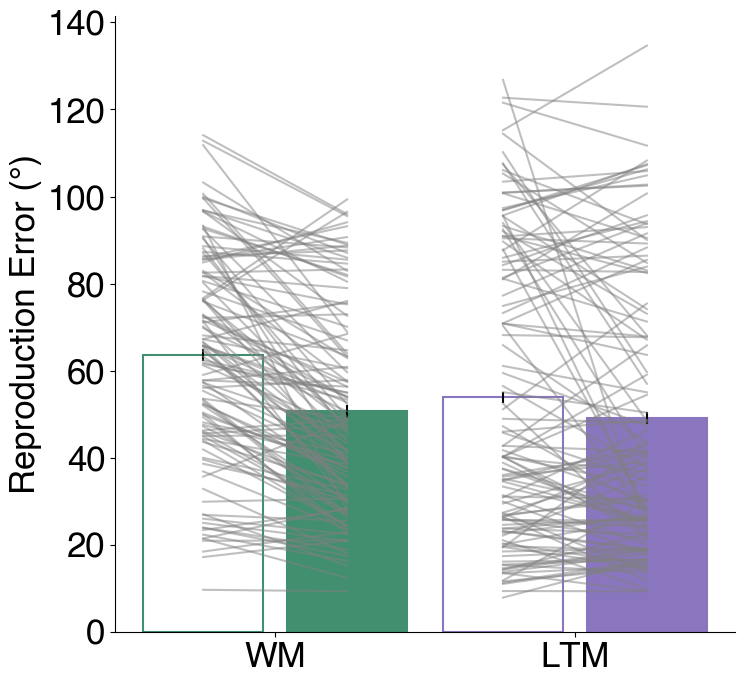

In [18]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

# reorder group_level_averages based on 'MemoryType' so that WM is plotted first

fig, ax = plt.subplots(figsize=(8, 8))
informative_means = group_level_averages[group_level_averages['CueCondition'] == 'Informative']['deviation']
# reorder the informative_means so that WM is plotted first
informative_means = informative_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'Neutral']['deviation']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, informative_means, width, label='Informative', color=[color_wm, color_ltm], edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
acc_data = acc_sub_avg.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='deviation')
# Calculate grand mean, subject means, and normalized data
grand_mean = acc_data.mean().mean()
subject_means = acc_data.mean(axis=1)
normalized_data = acc_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(acc_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
informative_se = corrected_se[:2]
# reorder the informative_se so that WM is plotted first
informative_se = informative_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]

# Add error bars
ax.errorbar(x + width*0.6, informative_means, yerr=informative_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)

# add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = acc_sub_avg[acc_sub_avg['MemoryType'] == memory_type]
    informative_data = participant_data[participant_data['CueCondition'] == 'Informative']
    neutral_data = participant_data[participant_data['CueCondition'] == 'Neutral']
    for participant in participant_ids:
        informative_deviation = informative_data[informative_data['ParticipantID'] == participant]['deviation'].values
        neutral_deviation = neutral_data[neutral_data['ParticipantID'] == participant]['deviation'].values
        # adjust the x position of the lines
        x_position = 0 if memory_type == 'WM' else 1
        plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_deviation,informative_deviation], color='grey', alpha=0.5)

        
ax.set_ylabel('Reproduction Error (°)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
# ax.set_title('Reproduction Errors by Memory Type and Cue Condition')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)
plt.show()

In [19]:
ltm_data = acc_sub_avg[acc_sub_avg['MemoryType'] == 'LTM']
# calculate the average deviation for each participant, collapsed across cue condition
ltm_data = ltm_data.groupby('ParticipantID')['deviation'].mean().reset_index()
# save the deviation data to a csv file
ltm_data.to_csv('ltm_deviation.csv', index=False)
# get a list of particpants whose deviation is smaller than 60
ltm_good_pids = ltm_data[ltm_data['deviation'] < 60]['ParticipantID'].tolist()
# do a median split and get two lists of participants
ltm_data['deviation_median'] = ltm_data['deviation'].median()
ltm_low_pids = ltm_data[ltm_data['deviation'] < ltm_data['deviation_median']]['ParticipantID'].tolist()
ltm_high_pids = ltm_data[ltm_data['deviation'] >= ltm_data['deviation_median']]['ParticipantID'].tolist()
# add informative and neutral columns from acc_data
ltm_data['informative'] = acc_data['LTM']['Informative'].values
ltm_data['neutral'] = acc_data['LTM']['Neutral'].values
ltm_data['reproduction_benefit'] = ltm_data['neutral'] - ltm_data['informative']
ltm_data['rt_informative'] = rt_data['LTM']['Informative'].values
ltm_data['rt_neutral'] = rt_data['LTM']['Neutral'].values
ltm_data['reproduction_rt_benefit'] = ltm_data['rt_neutral'] - ltm_data['rt_informative']

wm_data = acc_sub_avg[acc_sub_avg['MemoryType'] == 'WM']
# calculate the average deviation for each participant, collapsed across cue condition, 
wm_data = wm_data.groupby('ParticipantID')['deviation'].mean().reset_index()
# add informative and neutral columns from acc_data
wm_data['informative'] = acc_data['WM']['Informative'].values
wm_data['neutral'] = acc_data['WM']['Neutral'].values
wm_data['reproduction_benefit'] = wm_data['neutral'] - wm_data['informative']
wm_data['rt_informative'] = rt_data['WM']['Informative'].values
wm_data['rt_neutral'] = rt_data['WM']['Neutral'].values
wm_data['reproduction_rt_benefit'] = wm_data['rt_neutral'] - wm_data['rt_informative']


In [20]:
acc_data['LTM_cue_effect'] = acc_data['LTM']['Informative'] - acc_data['LTM']['Neutral']
acc_data['WM_cue_effect'] = acc_data['WM']['Informative'] - acc_data['WM']['Neutral']
# create a new dataframe for retrocue effect on deviation
cue_effect = pd.DataFrame()
cue_effect['ParticipantID'] = acc_data.index
cue_effect['LTM_cue_effect'] = acc_data['LTM_cue_effect'].values
cue_effect['WM_cue_effect'] = acc_data['WM_cue_effect'].values
cue_effect = pd.melt(cue_effect, id_vars='ParticipantID', value_vars=['LTM_cue_effect', 'WM_cue_effect'], var_name='variable', value_name='CueEffect')
cue_effect['MemoryType'] = cue_effect['variable'].str.extract(r'(LTM|WM)_', expand=True)
cue_effect.drop(columns='variable', inplace=True)



In [21]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=acc_sub_avg, depvar='deviation', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
# print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=acc_sub_avg, dv='deviation', within=['MemoryType', 'CueCondition'], subject='ParticipantID',effsize="np2")


Source           SS  ddof1  ddof2           MS  \
0                 MemoryType  3798.741754      1    118  3798.741754   
1               CueCondition  9184.797910      1    118  9184.797910   
2  MemoryType * CueCondition  1969.050527      1    118  1969.050527   

           F         p-unc     p-GG-corr       np2  eps  
0   6.947296  9.522727e-03  9.522727e-03  0.055602  1.0  
1  55.518992  1.677694e-11  1.677694e-11  0.319959  1.0  
2  15.215687  1.599149e-04  1.599149e-04  0.114218  1.0

In [22]:

# perform a paired-samples (informative vs neutral) t-test for WM and LTM separately
# WM
# Informative cue
informative_wm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'WM') & (acc_sub_avg['CueCondition'] == 'Informative')]['deviation']
# Neutral cue
neutral_wm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'WM') & (acc_sub_avg['CueCondition'] == 'Neutral')]['deviation']
# Perform the t-test
pg.ttest(informative_wm, neutral_wm, paired=True)


T  dof alternative         p-val            CI95%   cohen-d  \
T-test -9.581485  118   two-sided  1.967621e-16  [-15.51, -10.2]  0.540174   

             BF10     power  
T-test  3.054e+13  0.999949

In [23]:

# LTM
# Informative cue
informative_ltm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'LTM') & (acc_sub_avg['CueCondition'] == 'Informative')]['deviation']
# Neutral cue
neutral_ltm = acc_sub_avg[(acc_sub_avg['MemoryType'] == 'LTM') & (acc_sub_avg['CueCondition'] == 'Neutral')]['deviation']
# Perform the t-test
pg.ttest(informative_ltm, neutral_ltm, paired=True)



T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test -2.655619  118   two-sided  0.00901  [-8.24, -1.2]  0.143495  2.897   

           power  
T-test  0.342096

In [24]:
# Perform the t-test
pg.ttest(neutral_wm, neutral_ltm, paired=True)

T  dof alternative     p-val          CI95%   cohen-d    BF10  \
T-test  3.806967  118   two-sided  0.000225  [4.66, 14.77]  0.330992  81.597   

           power  
T-test  0.947512

In [25]:
# subtract informative from neutral for both WM and LTM, and do a paired t-test
# Subtract neutral from informative (need to transform neutral and informative from Series to numpy array)
diff_wm = informative_wm.values - neutral_wm.values
diff_ltm = informative_ltm.values - neutral_ltm.values
# Perform the t-test
pg.ttest(diff_wm, diff_ltm, paired=True)

T  dof alternative    p-val            CI95%   cohen-d  \
T-test -3.900729  118   two-sided  0.00016  [-12.27, -4.01]  0.473793   

           BF10     power  
T-test  111.737  0.999227

# Below is the code for the analysis of the percept task data

In [26]:
# Define the ParticipantID-integer mappings, read from mapping.json
import json
with open('../mapping.json', 'r') as f:
    participant_id_mapping = json.load(f)


In [27]:
# Define CueCondition
def determine_cue_condition(row, wm_locs, ltm_locs):
    cue_loc = row['cueLoc']
    if cue_loc == 'neutral':
        return 'neutral'
    else:
        # Convert cueLoc to number
        locs_mapping = {'wm1': wm_locs[0], 'wm2': wm_locs[1], 'ltm1': ltm_locs[0], 'ltm2': ltm_locs[1]}
        cue_loc_num = locs_mapping.get(cue_loc, None)
        
        # Determine matching or nonmatching
        if cue_loc_num == row['perceptLoc']:
            return 'matching'
        else:
            return 'nonmatching'

In [28]:

# Initialize a list to store percept_trials dataframes for all participants
all_percept_trials = []
for file_path,n in zip(participant_files,range(len(participant_files))):
    # Extract ParticipantID from the filename
    filename = Path(file_path).stem
    participant_id = filename.split('_')[0]
    participant_group = participant_id_mapping[participant_id]['group']
    
    # Determine WM and LTM locs based on the ParticipantID integer
    if participant_group == 'A':  # Even number
        ltm_locs = [1, 4]
        wm_locs = [2, 3]
    else:  # Odd number
        ltm_locs = [2, 3]
        wm_locs = [1, 4]
    
    # Load data
    data = pd.read_csv(file_path)
    test_trial_start_index = data['PracBlockEnd.stopped'].first_valid_index() + 1
    test_trials = data.iloc[test_trial_start_index:]
    # Filter for 'percept' taskType
    percept_trials = test_trials[test_trials['taskType'] == 'percept'].copy()
    # Define MemoryType based on perceptLoc
    percept_trials['MemoryType'] = percept_trials['perceptLoc'].apply(
        lambda x: 'WM' if x in wm_locs else 'LTM'
    )
    
    percept_trials['CueCondition'] = percept_trials.apply(lambda row: determine_cue_condition(row, wm_locs, ltm_locs), axis=1)
    percept_trials['ParticipantID'] = participant_ids[n]
    # Select and rename required variables
    percept_trials = percept_trials.rename(columns={'PerceptProbeKey.rt': 'RT', 'PerceptProbeKey.corr': 'Accuracy'})
    percept_trials = percept_trials[['ParticipantID', 'RT', 'Accuracy', 'MemoryType', 'CueCondition']]
    
    # Append to the list
    all_percept_trials.append(percept_trials)

# Concatenate all participant data
all_percept_trials_df = pd.concat(all_percept_trials, ignore_index=True)
# convert accuracy to percentage
all_percept_trials_df['Accuracy'] = all_percept_trials_df['Accuracy'] * 100
# Identify and exclude outlier trials where the rection time is over 3 SD criterion larger or smaller than the mean. Calculate the mean and standard deviation of the reaction time for each participant.
all_percept_trials_df['RT'] = all_percept_trials_df['RT'].astype(float)
for pid in participant_ids:
    participant_data = all_percept_trials_df[all_percept_trials_df['ParticipantID'] == pid]
    mean_time = participant_data['RT'].mean()
    std_time = participant_data['RT'].std()
    participant_data['outlier'] = (participant_data['RT'] < mean_time - 3 * std_time) | (participant_data['RT'] > mean_time + 3 * std_time)
    all_percept_trials_df.loc[all_percept_trials_df['ParticipantID'] == pid, 'outlier'] = participant_data['outlier']
# Caluclate the rate of outlier trials for each participant
outlier_rates = all_percept_trials_df.groupby('ParticipantID')['outlier'].mean()
# Calculate the average rate and standard deviation of outlier trials across all participants
mean_outlier_rate = outlier_rates.mean()
std_outlier_rate = outlier_rates.std()
print(f'Mean outlier rate: {mean_outlier_rate:.3f} ± {std_outlier_rate:.3f}')

# Calculate the overall rate of outlier trials
outlier_trials = all_percept_trials_df[all_percept_trials_df['outlier'] == True]
outlier_trials_count = outlier_trials.shape[0]
outlier_trials_rate = outlier_trials_count / all_percept_trials_df.shape[0]
print(f'Rate of outlier trials: {outlier_trials_rate:.3f}')

percept_task_data = all_percept_trials_df

# Exclude outlier trials
all_percept_trials_df = all_percept_trials_df[all_percept_trials_df['outlier'] == False]


Mean outlier rate: 0.016 ± 0.008
Rate of outlier trials: 0.016


In [29]:
all_percept_trials_df['MemoryType'].value_counts()

MemoryType
LTM    13967
WM     13928
Name: count, dtype: int64

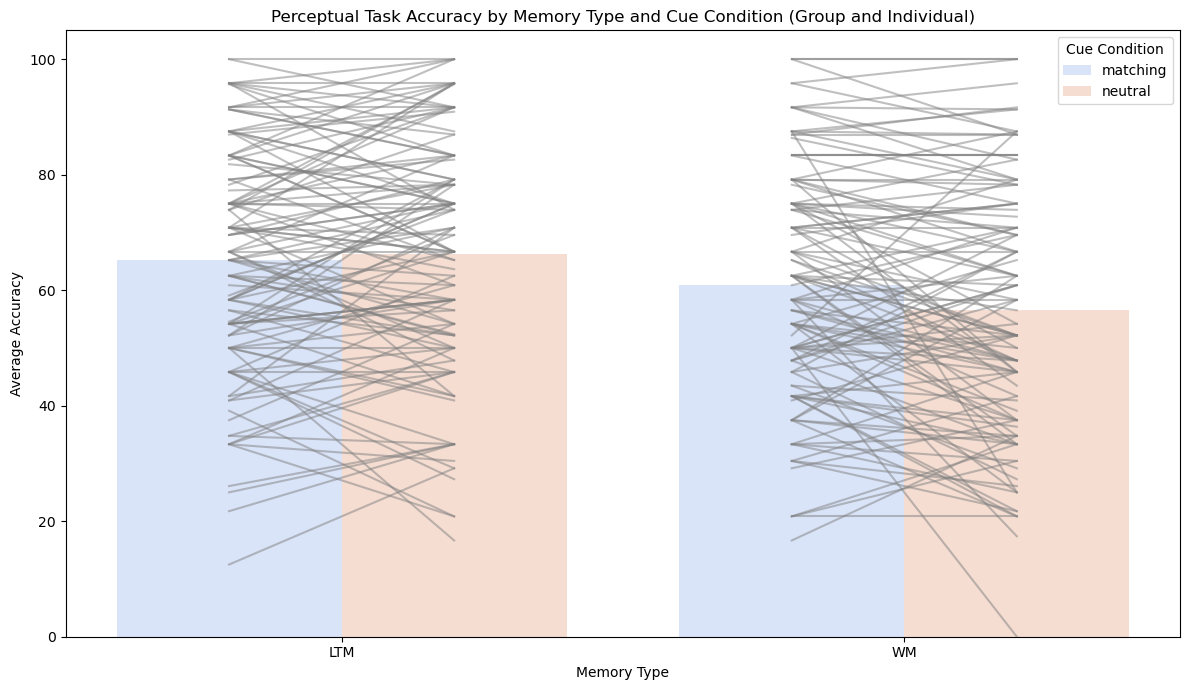

In [48]:
# Group data by MemoryType and CueCondition for accuracy analysis
grouped_data = all_percept_trials_df.groupby(['MemoryType', 'CueCondition'])['Accuracy'].mean().reset_index()
# Calculate within-participant averages, considering both MemoryType and CueCondition
within_participant_averages = all_percept_trials_df.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['Accuracy'].mean().reset_index()

# ****************************************************************************
# filter to include only participants with deviation less than 60
# ltm_participants = ltm_data['ParticipantID'][ltm_data['deviation'] < 30]
# within_participant_averages = within_participant_averages[within_participant_averages['ParticipantID'].isin(ltm_participants)]
# ****************************************************************************

# Calculate group-level averages, considering both MemoryType and CueCondition
group_level_averages = within_participant_averages.groupby(['MemoryType', 'CueCondition'])['Accuracy'].mean().reset_index()

# Plotting with cue conditions
plt.figure(figsize=(12, 7))
# plot only matching and neutral cue conditions: barplot, with standard-error(se) error bars
sns.barplot(x='MemoryType', y='Accuracy', hue='CueCondition', data=group_level_averages[group_level_averages['CueCondition'] != 'nonmatching'], palette='coolwarm', errorbar='sd', alpha=0.5)
# Add individual participant lines conecting matching and neutral cue conditions. let's do this for each memory type - make sure the lines are plotted at the right x position
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    matching_data = participant_data[participant_data['CueCondition'] == 'matching']
    neutral_data = participant_data[participant_data['CueCondition'] == 'neutral']
    for participant in participant_ids:
        matching_accuracy = matching_data[matching_data['ParticipantID'] == participant]['Accuracy'].values
        neutral_accuracy = neutral_data[neutral_data['ParticipantID'] == participant]['Accuracy'].values
        # adjust the x position of the lines
        x_position = 1 if memory_type == 'WM' else 0
        plt.plot([x_position-0.2, x_position+0.2], [matching_accuracy, neutral_accuracy], color='grey', alpha=0.5)
# sns.stripplot(x='MemoryType', y='Accuracy', data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], hue='CueCondition', dodge=True, palette='coolwarm', marker='o', size=8, alpha=1)
plt.title('Perceptual Task Accuracy by Memory Type and Cue Condition (Group and Individual)')
plt.xlabel('Memory Type')
plt.ylabel('Average Accuracy')
plt.legend(title='Cue Condition')
plt.tight_layout()
plt.show()

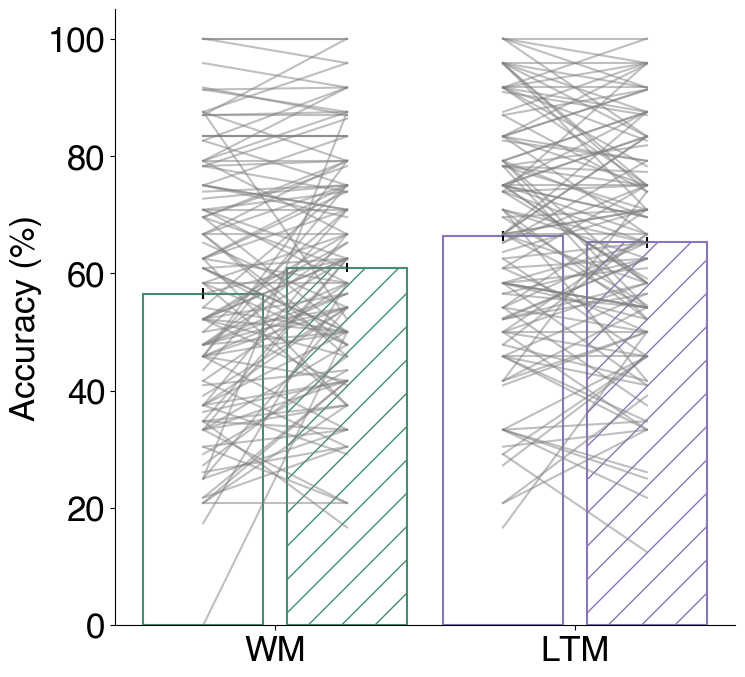

In [49]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
matching_means = group_level_averages[group_level_averages['CueCondition'] == 'matching']['Accuracy']
# reorder the matching_means so that WM is plotted first
matching_means = matching_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'neutral']['Accuracy']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, matching_means, width, label='Matching', color='none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-',hatch="/")
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
acc_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='Accuracy')
# remove the nonmatching condition
acc_data = acc_data.drop(columns='nonmatching', level=1)
# Calculate grand mean, subject means, and normalized data
grand_mean = acc_data.mean().mean()
subject_means = acc_data.mean(axis=1)
normalized_data = acc_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(acc_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
matching_se = corrected_se[:2]
# reorder the matching_se so that WM is plotted first
matching_se = matching_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]

# Add error bars
ax.errorbar(x + width*0.6, matching_means, yerr=matching_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)


# add individual participant lines
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    matching_data = participant_data[participant_data['CueCondition'] == 'matching']
    neutral_data = participant_data[participant_data['CueCondition'] == 'neutral']
    for participant in participant_ids:
        matching_accuracy = matching_data[matching_data['ParticipantID'] == participant]['Accuracy'].values
        neutral_accuracy = neutral_data[neutral_data['ParticipantID'] == participant]['Accuracy'].values
        # adjust the x position of the lines
        x_position = 0 if memory_type == 'WM' else 1
        plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_accuracy,matching_accuracy], color='grey', alpha=0.5)

ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(0, None)
# ax.set_title('Perceptual Task Accuracy')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)

plt.show()



# Nonmatching vs. neutral

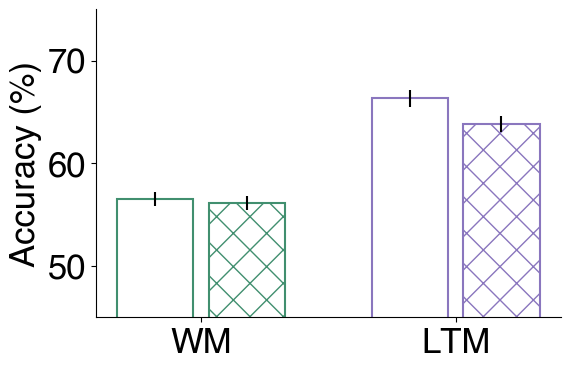

In [64]:
conditions = ('WM', 'LTM')
x = np.arange(len(conditions))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
nonmatching_means = group_level_averages[group_level_averages['CueCondition'] == 'nonmatching']['Accuracy']
# reorder the matching_means so that WM is plotted first
nonmatching_means = nonmatching_means.to_list()[::-1]
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'neutral']['Accuracy']
# reorder the neutral_means so that WM is plotted first
neutral_means = neutral_means.to_list()[::-1]
rects1 = ax.bar(x + width*0.6, nonmatching_means, width, label='Matching', color='none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-',hatch="x")
rects2 = ax.bar(x - width*0.6, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_wm, color_ltm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
acc_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='Accuracy')
# remove the matching condition
acc_data = acc_data.drop(columns='matching', level=1)
# Calculate grand mean, subject means, and normalized data
grand_mean = acc_data.mean().mean()
subject_means = acc_data.mean(axis=1)
normalized_data = acc_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(acc_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor
corrected_se = corrected_se.to_list()
nonmatching_se = corrected_se[:2]
# reorder the matching_se so that WM is plotted first
nonmatching_se = nonmatching_se[::-1]
neutral_se = corrected_se[2:]
# reorder the neutral_se so that WM is plotted first
neutral_se = neutral_se[::-1]

# Add error bars
ax.errorbar(x + width*0.6, nonmatching_means, yerr=nonmatching_se, fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width*0.6, neutral_means, yerr=neutral_se, fmt='none', ecolor='black', capsize=0)


# add individual participant lines
# for memory_type in ['WM', 'LTM']:
#     participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
#     nonmatching_data = participant_data[participant_data['CueCondition'] == 'nonmatching']
#     neutral_data = participant_data[participant_data['CueCondition'] == 'neutral']
#     for participant in participant_ids:
#         nonmatching_accuracy = nonmatching_data[nonmatching_data['ParticipantID'] == participant]['Accuracy'].values
#         neutral_accuracy = neutral_data[neutral_data['ParticipantID'] == participant]['Accuracy'].values
#         # adjust the x position of the lines
#         x_position = 0 if memory_type == 'WM' else 1
#         plt.plot([x_position - width*0.6, x_position + width*0.6], [neutral_accuracy,nonmatching_accuracy], color='grey', alpha=0.5)

ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_yticks([50,60,70])
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(45, 75)
# ax.set_title('Perceptual Task Accuracy')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)

plt.show()



In [33]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], depvar='Accuracy', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], dv='Accuracy', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType              32.2130 1.0000 118.0000 0.0000
CueCondition             3.4729 1.0000 118.0000 0.0649
MemoryType:CueCondition 10.3281 1.0000 118.0000 0.0017



Source           SS  ddof1  ddof2           MS  \
0                 MemoryType  5979.385420      1    118  5979.385420   
1               CueCondition   341.174981      1    118   341.174981   
2  MemoryType * CueCondition   877.494567      1    118   877.494567   

           F         p-unc     p-GG-corr       np2  eps  
0  32.212977  1.005380e-07  1.005380e-07  0.214449  1.0  
1   3.472917  6.486710e-02  6.486710e-02  0.028590  1.0  
2  10.328093  1.689764e-03  1.689764e-03  0.080482  1.0

In [34]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], depvar='Accuracy', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], dv='Accuracy', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType              54.6109 1.0000 118.0000 0.0000
CueCondition             4.3707 1.0000 118.0000 0.0387
MemoryType:CueCondition  3.0149 1.0000 118.0000 0.0851



Source           SS  ddof1  ddof2           MS  \
0                 MemoryType  9091.132009      1    118  9091.132009   
1               CueCondition   239.772218      1    118   239.772218   
2  MemoryType * CueCondition   134.596955      1    118   134.596955   

           F         p-unc     p-GG-corr       np2  eps  
0  54.610866  2.298745e-11  2.298745e-11  0.316381  1.0  
1   4.370668  3.870936e-02  3.870936e-02  0.035717  1.0  
2   3.014858  8.511465e-02  8.511465e-02  0.024913  1.0

In [35]:
# perform a paired-samples (matching vs neutral) t-test for WM and LTM separately
# WM
# Matching cue
matching_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'matching')]['Accuracy']
# Neutral cue
neutral_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'neutral')]['Accuracy']
# Perform the t-test
pg.ttest(matching_wm, neutral_wm, paired=True)


T  dof alternative     p-val         CI95%   cohen-d    BF10  \
T-test  3.308055  118   two-sided  0.001246  [1.77, 7.05]  0.213807  16.994   

           power  
T-test  0.638106

In [36]:

# LTM
# Matching cue
matching_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'matching')]['Accuracy']
# Neutral cue
neutral_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'neutral')]['Accuracy']
# Perform the t-test
pg.ttest(matching_ltm, neutral_ltm, paired=True)


T  dof alternative     p-val          CI95%   cohen-d  BF10  \
T-test -0.895605  118   two-sided  0.372287  [-3.28, 1.24]  0.051942  0.15   

         power  
T-test  0.0869

In [37]:
# subtract matching from neutral for both WM and LTM, and do a paired t-test
# Subtract neutral from matching (need to transform neutral and matching from Series to numpy array)
diff_wm = matching_wm.values - neutral_wm.values
diff_ltm = matching_ltm.values - neutral_ltm.values
# Perform the t-test
pg.ttest(diff_wm, diff_ltm, paired=True)

# # get the mean and standard error of diff_wm and diff_ltm
# mean_diff_wm = np.mean(diff_wm)
# se_diff_wm = np.std(diff_wm)/np.sqrt(len(diff_wm))
# mean_diff_ltm = np.mean(diff_ltm)
# se_diff_ltm = np.std(diff_ltm)/np.sqrt(len(diff_ltm))
# print(f'Mean difference for WM: {mean_diff_wm:.3f} ± {se_diff_wm:.3f}')
# print(f'Mean difference for LTM: {mean_diff_ltm:.3f} ± {se_diff_ltm:.3f}')

T  dof alternative    p-val         CI95%  cohen-d    BF10  \
T-test  3.213735  118   two-sided  0.00169  [2.08, 8.78]  0.40125  12.893   

           power  
T-test  0.991374

In [39]:
# ltm_data['percpet_acc_matching'] = acc_data['LTM']['matching'].values
# wm_data['percpet_acc_matching'] = acc_data['WM']['matching'].values

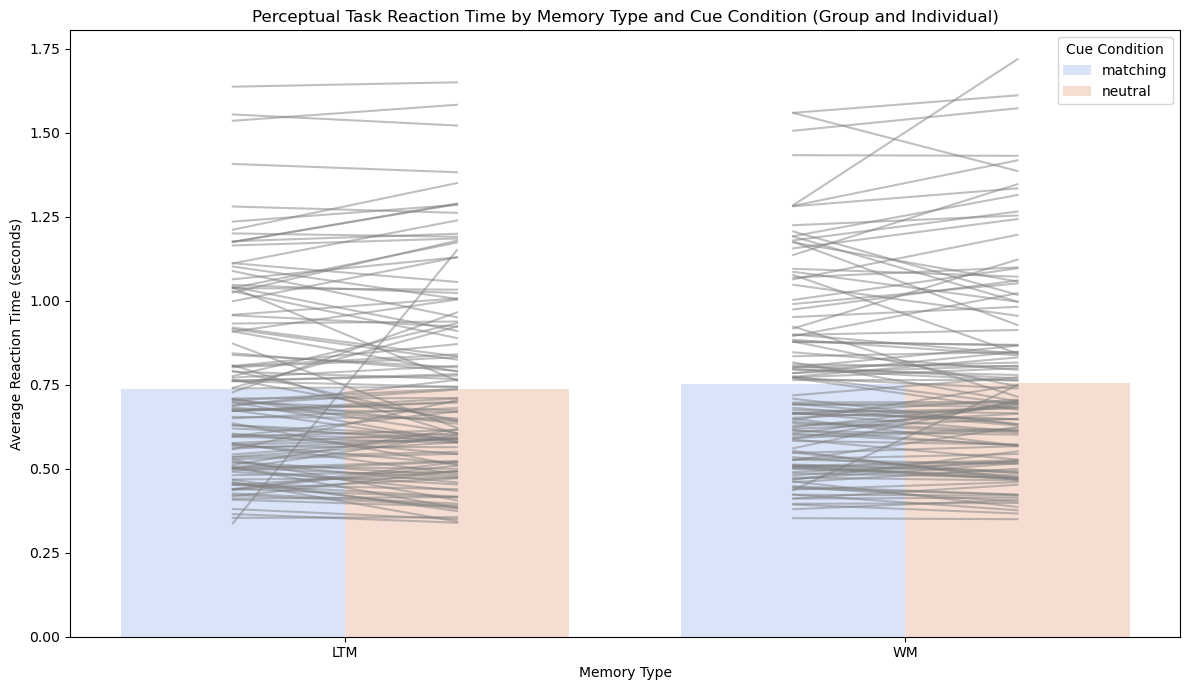

In [40]:
# Group data by MemoryType and CueCondition
grouped_data = all_percept_trials_df.groupby(['MemoryType', 'CueCondition'])['RT'].mean().reset_index()
# Calculate within-participant averages for RT, considering both MemoryType and CueCondition
within_participant_averages = all_percept_trials_df.groupby(['ParticipantID', 'MemoryType', 'CueCondition'])['RT'].mean().reset_index()
# Calculate group-level averages for RT, considering both MemoryType and CueCondition
group_level_averages = within_participant_averages.groupby(['MemoryType', 'CueCondition'])['RT'].mean().reset_index()
# Plotting with cue conditions
plt.figure(figsize=(12, 7))
# plot only matching and neutral cue conditions
sns.barplot(x='MemoryType', y='RT', hue='CueCondition', data=group_level_averages[group_level_averages['CueCondition'] != 'nonmatching'], palette='coolwarm', errorbar=None, alpha=0.5)
# Add individual participant lines conecting matching and neutral cue conditions. let's do this for each memory type - make sure the lines are plotted at the right x position
for memory_type in ['WM', 'LTM']:
    participant_data = within_participant_averages[within_participant_averages['MemoryType'] == memory_type]
    matching_data = participant_data[participant_data['CueCondition'] == 'matching']
    neutral_data = participant_data[participant_data['CueCondition'] == 'neutral']
    for participant in participant_ids:
        matching_rt = matching_data[matching_data['ParticipantID'] == participant]['RT'].values
        neutral_rt = neutral_data[neutral_data['ParticipantID'] == participant]['RT'].values
        # adjust the x position of the lines
        x_position = 1 if memory_type == 'WM' else 0
        plt.plot([x_position-0.2, x_position+0.2], [matching_rt, neutral_rt], color='grey', alpha=0.5)
# sns.stripplot(x='MemoryType', y='RT', data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], hue='CueCondition', dodge=True, palette='coolwarm', marker='o', size=8, alpha=1)
plt.title('Perceptual Task Reaction Time by Memory Type and Cue Condition (Group and Individual)')
plt.xlabel('Memory Type')
plt.ylabel('Average Reaction Time (seconds)')
plt.legend(title='Cue Condition')
plt.tight_layout()
plt.show()

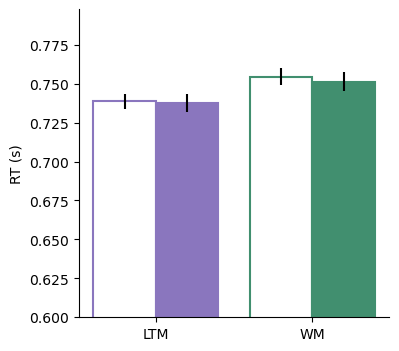

In [41]:
conditions = ('LTM', 'WM')
x = np.arange(len(conditions))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 4))
matching_means = group_level_averages[group_level_averages['CueCondition'] == 'matching']['RT']
neutral_means = group_level_averages[group_level_averages['CueCondition'] == 'neutral']['RT']
rects1 = ax.bar(x + width/2, matching_means, width, label='Matching', color=[color_ltm, color_wm], edgecolor=[color_ltm, color_wm], linewidth=1.5, linestyle='-')
rects2 = ax.bar(x - width/2, neutral_means, width, label='Neutral', color= 'none', edgecolor=[color_ltm, color_wm], linewidth=1.5, linestyle='-')

# choose from within_participant_averages the accuracy data for each condition(combine memory type and cue condition)
rt_data = within_participant_averages.pivot_table(index='ParticipantID', columns=['MemoryType', 'CueCondition'], values='RT')
# remove the nonmatching condition
rt_data = rt_data.drop(columns='nonmatching', level=1)
# Calculate grand mean, subject means, and normalized data
grand_mean = rt_data.mean().mean()
subject_means = rt_data.mean(axis=1)
normalized_data = rt_data.subtract(subject_means, axis=0).add(grand_mean, axis=0)

# Calculate standard error and correction factor
se = normalized_data.sem()
n_subjects = len(rt_data)
correction_factor = np.sqrt(n_subjects / (n_subjects - 1))
corrected_se = se * correction_factor

# Add error bars
ax.errorbar(x + width/2, matching_means, yerr=corrected_se[:2], fmt='none', ecolor='black', capsize=0)
ax.errorbar(x - width/2, neutral_means, yerr=corrected_se[2:], fmt='none', ecolor='black', capsize=0)

ax.set_ylabel('RT (s)')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set y axis limits
ax.set_ylim(0.6, None)
# ax.set_title('Perceptual Task Accuracy')

plt.show()



In [42]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], depvar='RT', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'nonmatching'], dv='RT', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType               6.4192 1.0000 118.0000 0.0126
CueCondition             0.0999 1.0000 118.0000 0.7525
MemoryType:CueCondition  0.0247 1.0000 118.0000 0.8753



Source        SS  ddof1  ddof2        MS         F  \
0                 MemoryType  0.024905      1    118  0.024905  6.419171   
1               CueCondition  0.000527      1    118  0.000527  0.099936   
2  MemoryType * CueCondition  0.000131      1    118  0.000131  0.024717   

      p-unc  p-GG-corr       np2  eps  
0  0.012601   0.012601  0.051593  1.0  
1  0.752465   0.752465  0.000846  1.0  
2  0.875343   0.875343  0.000209  1.0

#Nonmatching

In [43]:
#perform two-way repeated measures ANOVA: (within-subject factor 1: MemoryType, within-subject factor 2: CueCondition)

# set up the repeated measures model
memory_model = AnovaRM(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], depvar='RT', subject='ParticipantID', within=['MemoryType', 'CueCondition'])
memory_fit = memory_model.fit()
# print the ANOVA table
print(memory_fit)
# do the same thing using pingouin
pg.rm_anova(data=within_participant_averages[within_participant_averages['CueCondition'] != 'matching'], dv='RT', within=['MemoryType', 'CueCondition'], subject='ParticipantID', effsize="np2")

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
MemoryType               3.9957 1.0000 118.0000 0.0479
CueCondition             9.4197 1.0000 118.0000 0.0027
MemoryType:CueCondition  0.2913 1.0000 118.0000 0.5904



Source        SS  ddof1  ddof2        MS         F  \
0                 MemoryType  0.019907      1    118  0.019907  3.995743   
1               CueCondition  0.031757      1    118  0.031757  9.419723   
2  MemoryType * CueCondition  0.000794      1    118  0.000794  0.291254   

      p-unc  p-GG-corr       np2  eps  
0  0.047914   0.047914  0.032753  1.0  
1  0.002664   0.002664  0.073927  1.0  
2  0.590435   0.590435  0.002462  1.0

In [44]:
# perform a paired-samples (matching vs neutral) t-test for WM and LTM separately
# WM
# Matching cue
matching_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'matching')]['RT']
# Neutral cue
neutral_wm = within_participant_averages[(within_participant_averages['MemoryType'] == 'WM') & (within_participant_averages['CueCondition'] == 'neutral')]['RT']
# Perform the t-test
pg.ttest(matching_wm, neutral_wm, paired=True)


T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.372478  118   two-sided  0.710205  [-0.02, 0.01]  0.010976  0.109   

           power  
T-test  0.051617

In [45]:

# LTM
# Matching cue
matching_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'matching')]['RT']
# Neutral cue
neutral_ltm = within_participant_averages[(within_participant_averages['MemoryType'] == 'LTM') & (within_participant_averages['CueCondition'] == 'neutral')]['RT']
# Perform the t-test
pg.ttest(matching_ltm, neutral_ltm, paired=True)


T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.102262  118   two-sided  0.918722  [-0.02, 0.02]  0.003665  0.102   

          power  
T-test  0.05018

In [46]:
# For `acc_data`, which is a pivot table, calculate the LTM acc benefit (LTM matching - LTM neutral) and WM acc benefit (WM matching - WM neutral) for each participant
# Then, calculate the grand mean of the LTM acc benefit and WM acc benefit
# Then, perform a paired-samples t-test for the two means

acc_data['LTM_acc_benefit'] = acc_data['LTM']['matching'] - acc_data['LTM']['neutral']
acc_data['WM_acc_benefit'] = acc_data['WM']['matching'] - acc_data['WM']['neutral']

mean_LTM_acc_benefit = acc_data['LTM_acc_benefit'].mean()
mean_WM_acc_benefit = acc_data['WM_acc_benefit'].mean()

pg.ttest(acc_data['LTM_acc_benefit'], acc_data['WM_acc_benefit'], paired=True)

KeyError: 'matching'

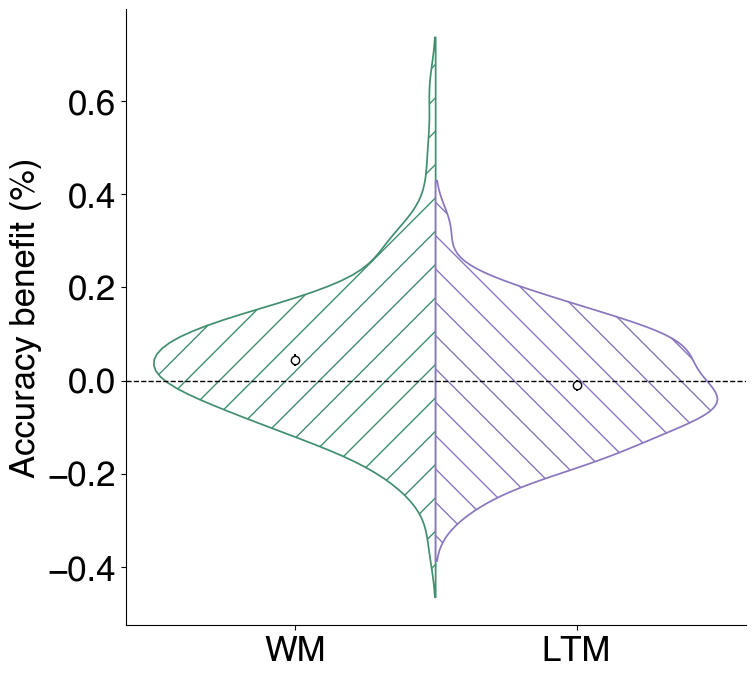

In [ ]:
# create a new dataframe for acc benefit and tranform to long form
# initiate an empty dataframe
benefit_data = pd.DataFrame()
# add the data from acc_data to the dataframe
benefit_data['ParticipantID'] = acc_data.index
# in the two lines below, be aware that it is multi-level indexing
benefit_data['LTM_acc_benefit'] = acc_data['LTM_acc_benefit'].values
benefit_data['WM_acc_benefit'] = acc_data['WM_acc_benefit'].values
# calculate the mean and sem of the acc benefit for each memory type
mean_LTM_acc_benefit = benefit_data['LTM_acc_benefit'].mean()
sem_LTM_acc_benefit = benefit_data['LTM_acc_benefit'].sem()
mean_WM_acc_benefit = benefit_data['WM_acc_benefit'].mean()
sem_WM_acc_benefit = benefit_data['WM_acc_benefit'].sem()

benefit_data = pd.melt(benefit_data, id_vars='ParticipantID', value_vars=['WM_acc_benefit', 'LTM_acc_benefit'], var_name='variable', value_name='Benefit')
# Extract the 'MemoryType' from the column names
benefit_data['MemoryType'] = benefit_data['variable'].str.extract(r'(WM|LTM)_', expand=True)
benefit_data.drop(columns='variable', inplace=True)
# add a column to serve as the x-axis for the violin plot
benefit_data['Memory Type'] = ''
# plot violin plot of the acc benefit for each memory type
fig, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(data=benefit_data, x='Memory Type', y="Benefit", hue="MemoryType", split=True, inner=None, palette=('white', 'white'),linecolor='white')

# Add hatching
for i, artist in enumerate(ax.collections):
    if i % 2 == 0:
        # WM cue
        artist.set_hatch('/')
        artist.set_edgecolor(color_wm)
    else:
        # LTM cue
        artist.set_hatch('\\')
        artist.set_edgecolor(color_ltm)

# draw a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# don't show legend
plt.legend().remove()
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



# remove the current x-axis labels and ticks, instead have two ticks located at 0.5, 1.5 for WM and LTM respectively

ax.errorbar(-0.2, mean_WM_acc_benefit, yerr=sem_WM_acc_benefit, fmt='o', color='black', capsize=0,markerfacecolor='white', markeredgecolor='black')
ax.errorbar(0.2, mean_LTM_acc_benefit, yerr=sem_LTM_acc_benefit, fmt='o', color='black', capsize=0,markerfacecolor='white', markeredgecolor='black')


ax.set_xticks([-0.2, 0.2])
ax.set_xticklabels(['WM', 'LTM'])

# remove x-axis label
ax.set_xlabel('')

# set y axis label
ax.set_ylabel('Accuracy benefit (%)')

# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)

plt.show()


In [ ]:
# we have cue_effect and ltm_data dataframes, let's do a linear regression to see if ltm deviation can predict cue_effect
# LTM
# extract the LTM performance and LTM acc benefit, include only participants with a ltm performance < 30, and the same participants in benefit data
ltm_participants = ltm_data['ParticipantID'][ltm_data['deviation'] < 60]
ltm_performance = ltm_data['informative'][ltm_data['ParticipantID'].isin(ltm_participants)]
ltm_benefit = benefit_data[benefit_data['MemoryType'] == 'LTM'][benefit_data['ParticipantID'].isin(ltm_participants)]['Benefit']

# normalize the performance and benefit data
ltm_performance = (ltm_performance - ltm_performance.mean()) / ltm_performance.std()
ltm_benefit = (ltm_benefit - ltm_benefit.mean()) / ltm_benefit.std()

# perform linear regression
ltm_table = pg.linear_regression(ltm_performance, ltm_benefit)
ltm_pval = ltm_table["pval"].values[1]
# perform correlation
ltm_cor = pg.corr(ltm_performance, ltm_benefit, method='pearson')
ltm_r = ltm_cor["r"].values[0]


In [ ]:
ltm_table

names      coef        se         T      pval        r2    adj_r2  \
0  Intercept  0.031264  0.073245  0.426837  0.671972  0.000369 -0.026649   
1  deviation -0.000416  0.003561 -0.116798  0.907652  0.000369 -0.026649   

   CI[2.5%]  CI[97.5%]  
0 -0.117145   0.179672  
1 -0.007631   0.006799

In [ ]:
ltm_cor

n         r         CI95%     p-val   BF10     power
pearson  39 -0.019198  [-0.33, 0.3]  0.907652  0.201  0.051155

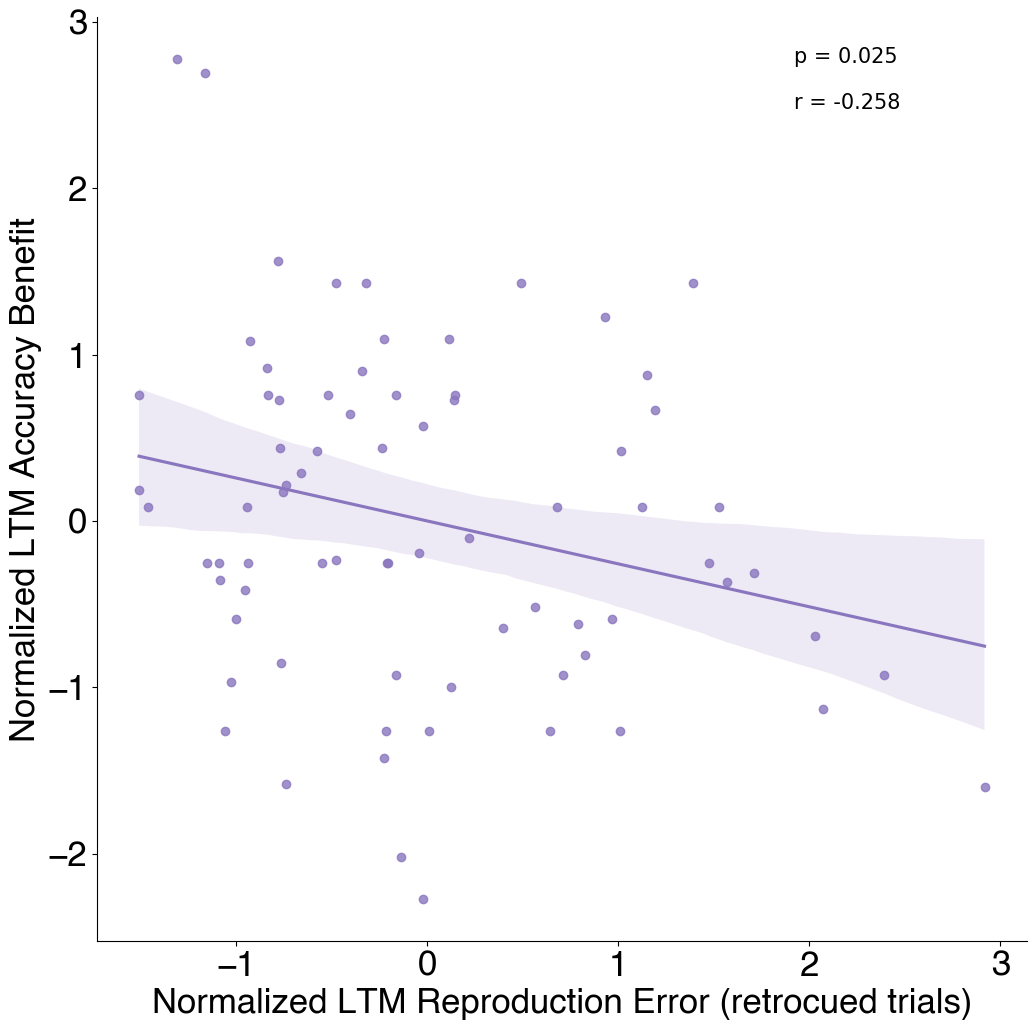

In [ ]:

# plot the regression line
fig, ax = plt.subplots(figsize=(12, 12))
sns.regplot(x=ltm_performance, y=ltm_benefit, color=color_ltm)
plt.xlabel('Normalized LTM Reproduction Error (retrocued trials)')
plt.ylabel('Normalized LTM Accuracy Benefit')
# plt.title('LTM Accuracy Benefit vs. Reproduction Error')
# add p value and r value to the plot
plt.text(0.75, 0.95, f'p = {ltm_pval:.3f}', transform=plt.gca().transAxes, fontsize=15)
plt.text(0.75, 0.90, f'r = {ltm_r:.3f}', transform=plt.gca().transAxes, fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)
plt.show()



In [ ]:
benefit_data[benefit_data['MemoryType'] == 'LTM']['Benefit']

119   -0.034420
120   -0.206522
121   -0.115942
122   -0.041667
123   -0.061594
         ...   
233    0.000000
234    0.101190
235   -0.134058
236   -0.250000
237    0.123188
Name: Benefit, Length: 119, dtype: float64

In [ ]:
# we have cue_effect and ltm_data dataframes, let's do a linear regression to see if ltm deviation can predict cue_effect
# LTM Accuray Benefit
# extract the LTM performance and LTM acc benefit, include only participants with a ltm reproduction benefit > 0, and the same participants in benefit data
ltm_participants = ltm_data['ParticipantID'][ltm_data['reproduction_benefit'] > 0]
ltm_reprodudction_benefit = ltm_data['reproduction_benefit'][ltm_data['ParticipantID'].isin(ltm_participants)]
ltm_percept_benefit = benefit_data[benefit_data['MemoryType'] == 'LTM'][benefit_data['ParticipantID'].isin(ltm_participants)]['Benefit']

#normalize the data before regression
ltm_reprodudction_benefit = (ltm_reprodudction_benefit - ltm_reprodudction_benefit.mean()) / ltm_reprodudction_benefit.std()
ltm_percept_benefit = (ltm_percept_benefit - ltm_percept_benefit.mean()) / ltm_percept_benefit.std()

# perform linear regression
ltm_table = pg.linear_regression(ltm_reprodudction_benefit, ltm_percept_benefit)
ltm_pval = ltm_table["pval"].values[1]
# perform correlation
ltm_cor = pg.corr(ltm_reprodudction_benefit, ltm_percept_benefit, method='pearson')
ltm_r = ltm_cor["r"].values[0]


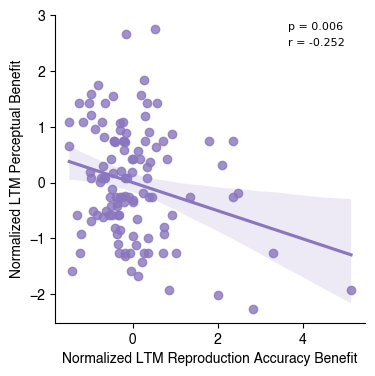

In [ ]:

# plot the regression line
fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(x=ltm_reprodudction_benefit, y=ltm_percept_benefit, color=color_ltm)
plt.xlabel('Normalized LTM Reproduction Accuracy Benefit')
plt.ylabel('Normalized LTM Perceptual Benefit')
# plt.title('LTM Accuracy Benefit vs. Reproduction Error')
# add p value and r value to the plot
plt.text(0.75, 0.95, f'p = {ltm_pval:.3f}', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.75, 0.90, f'r = {ltm_r:.3f}', transform=plt.gca().transAxes, fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(10)
plt.show()

In [ ]:
# we have cue_effect and ltm_data dataframes, let's do a linear regression to see if ltm deviation can predict cue_effect
# LTM RT Benefit
# extract the LTM performance and LTM acc benefit, include only participants with a ltm reproduction benefit > 0, and the same participants in benefit data
# ltm_participants = ltm_data['ParticipantID'][ltm_data['reproduction_benefit'] > 0]
ltm_reprodudction_benefit = ltm_data['reproduction_rt_benefit']
ltm_percept_benefit = benefit_data[benefit_data['MemoryType'] == 'LTM']['Benefit']

#normalize the data before regression
ltm_reprodudction_benefit = (ltm_reprodudction_benefit - ltm_reprodudction_benefit.mean()) / ltm_reprodudction_benefit.std()
ltm_percept_benefit = (ltm_percept_benefit - ltm_percept_benefit.mean()) / ltm_percept_benefit.std()

# perform linear regression
ltm_table = pg.linear_regression(ltm_reprodudction_benefit, ltm_percept_benefit)
ltm_pval = ltm_table["pval"].values[1]
# perform correlation
ltm_cor = pg.corr(ltm_reprodudction_benefit, ltm_percept_benefit, method='pearson')
ltm_r = ltm_cor["r"].values[0]


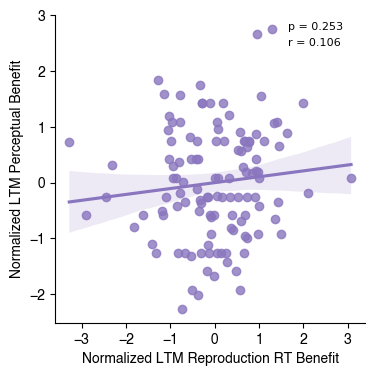

In [ ]:

# plot the regression line
fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(x=ltm_reprodudction_benefit, y=ltm_percept_benefit, color=color_ltm)
plt.xlabel('Normalized LTM Reproduction RT Benefit')
plt.ylabel('Normalized LTM Perceptual Benefit')
# plt.title('LTM Accuracy Benefit vs. Reproduction Error')
# add p value and r value to the plot
plt.text(0.75, 0.95, f'p = {ltm_pval:.3f}', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.75, 0.90, f'r = {ltm_r:.3f}', transform=plt.gca().transAxes, fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(10)
plt.show()

In [ ]:

# WM
# extract the WM performance and WM acc benefit, include only participants with a wm performance < 60, and the same participants in benefit data
wm_participants = wm_data['ParticipantID']
wm_performance = wm_data['informative']
wm_benefit = benefit_data[benefit_data['MemoryType'] == 'WM'][benefit_data['ParticipantID'].isin(wm_participants)]['Benefit']

# normalize the performance and benefit data
wm_performance = (wm_performance - wm_performance.mean()) / wm_performance.std()
wm_benefit = (wm_benefit - wm_benefit.mean()) / wm_benefit.std()

# perform linear regression
wm_table = pg.linear_regression(wm_performance, wm_benefit)
wm_pval = wm_table["pval"].values[1]
# perform correlation
wm_cor = pg.corr(wm_performance, wm_benefit, method='pearson')
wm_r = wm_cor["r"].values[0]


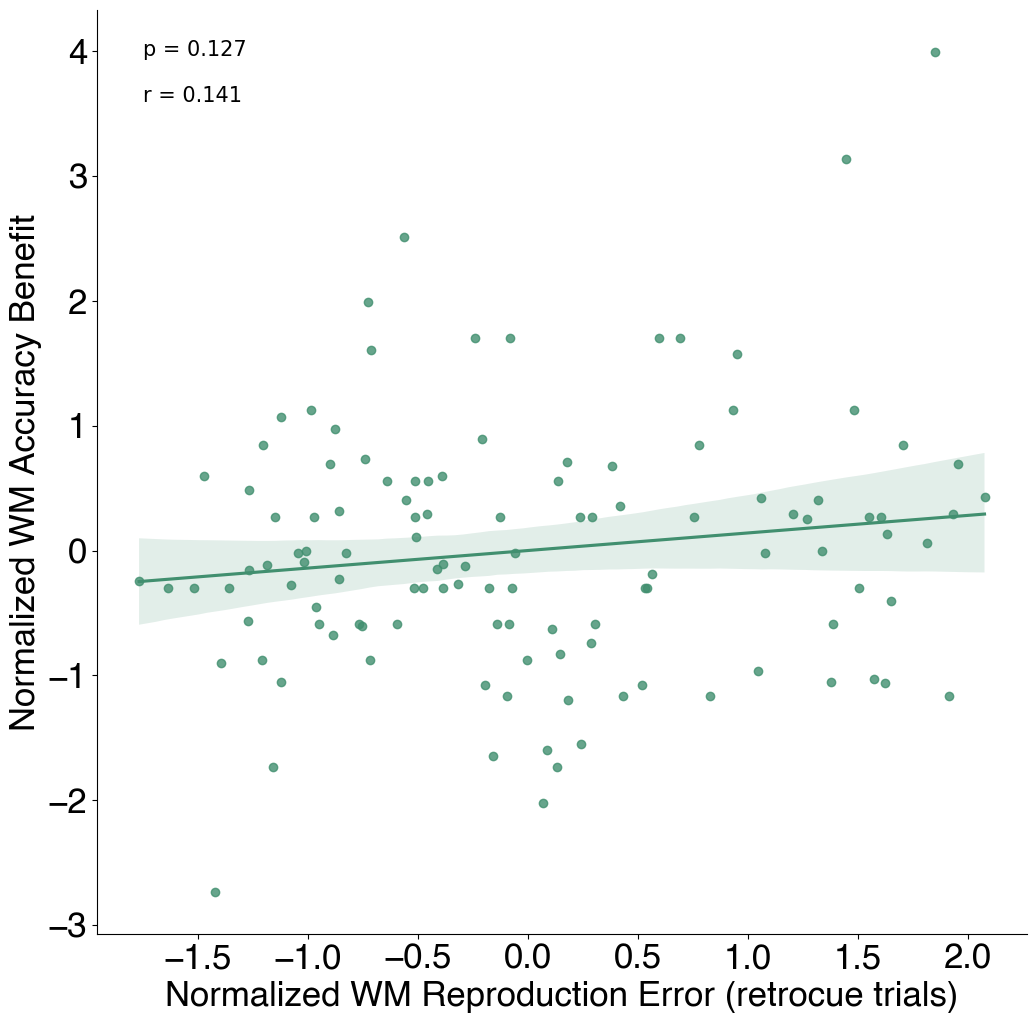

In [ ]:
# plot the regression line
fig, ax = plt.subplots(figsize=(12, 12))
sns.regplot(x=wm_performance, y=wm_benefit, color=color_wm)
plt.xlabel('Normalized WM Reproduction Error (retrocue trials)')
plt.ylabel('Normalized WM Accuracy Benefit')
# plt.title('WM Accuracy Benefit vs. Reproduction Error')
# add p value and r value to the plot
plt.text(0.05, 0.95, f'p = {wm_pval:.3f}', transform=plt.gca().transAxes, fontsize=15)
plt.text(0.05, 0.90, f'r = {wm_r:.3f}', transform=plt.gca().transAxes, fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(25)
plt.show()



In [ ]:
# WM Accuracy Benefit

# extract the WM performance and WM acc benefit, include only participants with a wm performance < 60, and the same participants in benefit data
# wm_participants = wm_data['ParticipantID'][wm_data['reproduction_benefit'] > 0]
wm_reproduction_benefit = wm_data['reproduction_benefit']
wm_percept_benefit = benefit_data[benefit_data['MemoryType'] == 'WM']['Benefit']

#normalize the data before regression
wm_reproduction_benefit = (wm_reproduction_benefit - wm_reproduction_benefit.mean()) / wm_reproduction_benefit.std()
wm_percept_benefit = (wm_percept_benefit - wm_percept_benefit.mean()) / wm_percept_benefit.std()

# perform linear regression
wm_table = pg.linear_regression(wm_reproduction_benefit, wm_percept_benefit)
wm_pval = wm_table["pval"].values[1]
# perform correlation
wm_cor = pg.corr(wm_reproduction_benefit, wm_percept_benefit, method='pearson')
wm_r = wm_cor["r"].values[0]


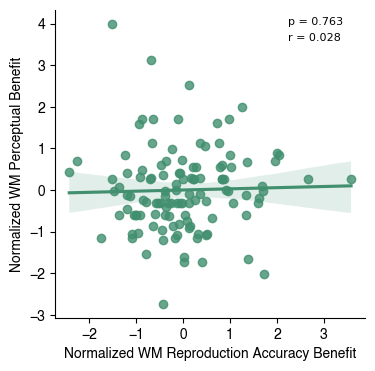

In [ ]:
# plot the regression line
fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(x=wm_reproduction_benefit, y=wm_percept_benefit, color=color_wm)
plt.xlabel('Normalized WM Reproduction Accuracy Benefit')
plt.ylabel('Normalized WM Perceptual Benefit')
# plt.title('LTM Accuracy Benefit vs. Reproduction Error')
# add p value and r value to the plot
plt.text(0.75, 0.95, f'p = {wm_pval:.3f}', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.75, 0.90, f'r = {wm_r:.3f}', transform=plt.gca().transAxes, fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(10)
plt.show()

In [ ]:

# WM RT Benefit
# extract the WM performance and WM acc benefit, include only participants with a wm performance < 60, and the same participants in benefit data
# wm_participants = wm_data['ParticipantID'][wm_data['reproduction_benefit'] > 0]
wm_reproduction_benefit = wm_data['reproduction_rt_benefit']
wm_percept_benefit = benefit_data[benefit_data['MemoryType'] == 'WM']['Benefit']

#normalize the data before regression
wm_reproduction_benefit = (wm_reproduction_benefit - wm_reproduction_benefit.mean()) / wm_reproduction_benefit.std()
wm_percept_benefit = (wm_percept_benefit - wm_percept_benefit.mean()) / wm_percept_benefit.std()

# perform linear regression
wm_table = pg.linear_regression(wm_reproduction_benefit, wm_percept_benefit)
wm_pval = wm_table["pval"].values[1]
# perform correlation
wm_cor = pg.corr(wm_reproduction_benefit, wm_percept_benefit, method='pearson')
wm_r = wm_cor["r"].values[0]


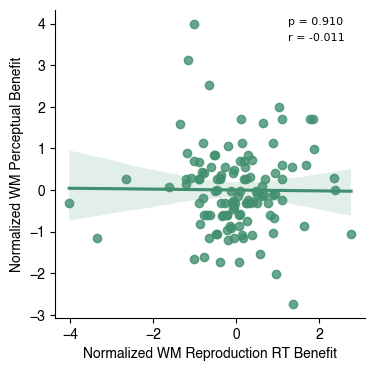

In [ ]:
# plot the regression line
fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(x=wm_reproduction_benefit, y=wm_percept_benefit, color=color_wm)
plt.xlabel('Normalized WM Reproduction RT Benefit')
plt.ylabel('Normalized WM Perceptual Benefit')
# plt.title('LTM Accuracy Benefit vs. Reproduction Error')
# add p value and r value to the plot
plt.text(0.75, 0.95, f'p = {wm_pval:.3f}', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.75, 0.90, f'r = {wm_r:.3f}', transform=plt.gca().transAxes, fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the axes font to Helvetica and set the font size to 25
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontname('Helvetica')
    item.set_fontsize(10)
plt.show()

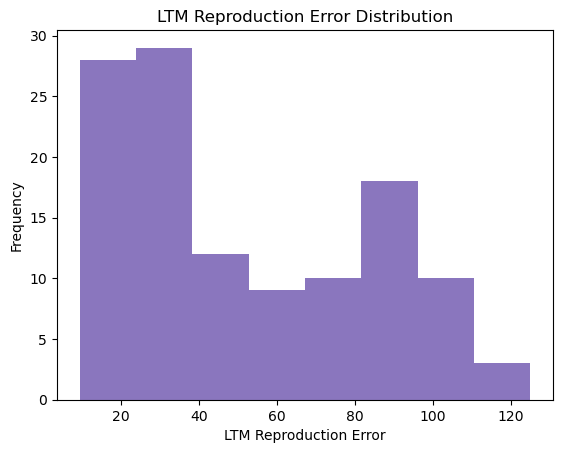

In [ ]:
# plot the histogram of deviation in ltm_data
plt.hist(ltm_data['deviation'], bins=8, color=color_ltm)
plt.xlabel('LTM Reproduction Error')
plt.ylabel('Frequency')
plt.title('LTM Reproduction Error Distribution')
plt.show()


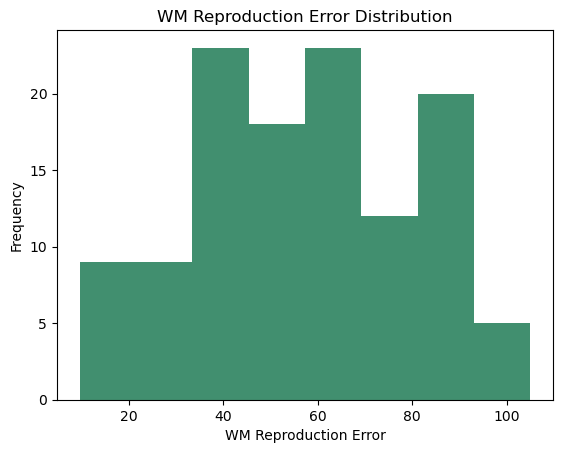

In [ ]:
# plot the histogram of deviation in wm_data
plt.hist(wm_data['deviation'], bins=8, color=color_wm)
plt.xlabel('WM Reproduction Error')
plt.ylabel('Frequency')
plt.title('WM Reproduction Error Distribution')
plt.show()

In [ ]:
# let's do rayleigh test for the deviation data for each participant, for LTM and WM separately, we'll use the all_participants_data dataframe
# LTM: extract the deviation data for each participant
for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    ltm_deviation = participant_data[participant_data['MemoryType'] == 'LTM']['deviation']
    ltm_deviation = np.array(ltm_deviation)*u.deg
    rayleigh_result = rayleightest(ltm_deviation)
    print(f'LTM, {pid}: p = {rayleigh_result:.3f}')

# WM: extract the deviation data for each participant
for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    wm_deviation = participant_data[participant_data['MemoryType'] == 'WM']['deviation']
    wm_deviation = np.array(wm_deviation)*u.deg
    rayleigh_result = rayleightest(wm_deviation)
    print(f'WM, {pid}: p = {rayleigh_result:.3f}')



LTM, 5c8bafb53b6f3d00013d7c30: p = 0.000
LTM, 5f21c29511084913913af654: p = 0.000
LTM, 5d453e8723a5bb0001492546: p = 0.000
LTM, 5f7014ba8655415e9dddc1b7: p = 0.000
LTM, 5f06eefaf3fc742667b4e79d: p = 0.000
LTM, 651eda4af4a809dbba0bb002: p = 0.000
LTM, 658405e29e9aac7350cdb75a: p = 0.000
LTM, 60bbc368a316ee5421a1153b: p = 0.000
LTM, 5d49d17b3dad1f0001e2aba1: p = 0.000
LTM, 5ed8cf4782a6eb04ddf9962d: p = 0.000
LTM, 5edab6df83998915303516d5: p = 0.000
LTM, 65e2b3b946ad361e29ccd504: p = 0.000
LTM, 5d6e3252dfe6d10001dbe508: p = 0.000
LTM, 607ec7379eac7be04ab448e3: p = 0.000
LTM, 596634e005f2df00017281ae: p = 0.000
LTM, 64a9c85cd18d2853ec8eca4d: p = 0.000
LTM, 5f63a2bc08a0080c790f8eb6: p = 0.000
LTM, 65aa815acfeb858f15d2cf29: p = 0.000
LTM, 60bf964f35e4cada9f7f03cc: p = 0.000
LTM, 63ea4564de250efaacb1cceb: p = 0.000
LTM, 60f5b42174aa93c2c1522ecf: p = 0.000
LTM, 5df5143f58a5c738d0e197af: p = 0.000
LTM, 5fc9ec3d0990d4501dfd7e05: p = 0.000
LTM, 65a2a4643cc27e9702199c43: p = 0.000
LTM, 60f814d5348

In [ ]:
import biased_memory_toolbox as bmt
# check if participant's performance is better than chance performance using bmt.test_chance_performance
for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    wm_response = participant_data[participant_data['MemoryType'] == 'WM']['selectedShape'].to_numpy()
    wm_truth = participant_data[participant_data['MemoryType'] == 'WM']['shapeTruth'].to_numpy().astype(float)
    wm_t, wm_p = bmt.test_chance_performance(wm_truth, wm_response)
    print(f'WM, {pid}: t = {wm_t:.3f}, p = {wm_p:.3f}')

    ltm_response = participant_data[participant_data['MemoryType'] == 'LTM']['selectedShape'].to_numpy()
    ltm_truth = participant_data[participant_data['MemoryType'] == 'LTM']['shapeTruth'].to_numpy().astype(float)
    ltm_t, ltm_p = bmt.test_chance_performance(ltm_truth, ltm_response)
    print(f'LTM, {pid}: t = {ltm_t:.3f}, p = {ltm_p:.3f}')



WM, 5c8bafb53b6f3d00013d7c30: t = -0.210, p = 0.833
LTM, 5c8bafb53b6f3d00013d7c30: t = -1.138, p = 0.256
WM, 5f21c29511084913913af654: t = -2.859, p = 0.005
LTM, 5f21c29511084913913af654: t = -4.146, p = 0.000
WM, 5d453e8723a5bb0001492546: t = -4.695, p = 0.000
LTM, 5d453e8723a5bb0001492546: t = -6.264, p = 0.000
WM, 5f7014ba8655415e9dddc1b7: t = -3.584, p = 0.000
LTM, 5f7014ba8655415e9dddc1b7: t = -7.128, p = 0.000
WM, 5f06eefaf3fc742667b4e79d: t = 0.778, p = 0.437
LTM, 5f06eefaf3fc742667b4e79d: t = -2.058, p = 0.041
WM, 651eda4af4a809dbba0bb002: t = -1.866, p = 0.063
LTM, 651eda4af4a809dbba0bb002: t = -6.684, p = 0.000
WM, 658405e29e9aac7350cdb75a: t = -1.388, p = 0.166
LTM, 658405e29e9aac7350cdb75a: t = -5.389, p = 0.000
WM, 60bbc368a316ee5421a1153b: t = -1.498, p = 0.136
LTM, 60bbc368a316ee5421a1153b: t = -3.309, p = 0.001
WM, 5d49d17b3dad1f0001e2aba1: t = -2.069, p = 0.040
LTM, 5d49d17b3dad1f0001e2aba1: t = -0.092, p = 0.927
WM, 5ed8cf4782a6eb04ddf9962d: t = -6.058, p = 0.000
LTM,

WM, 5c8bafb53b6f3d00013d7c30: p = 0.506


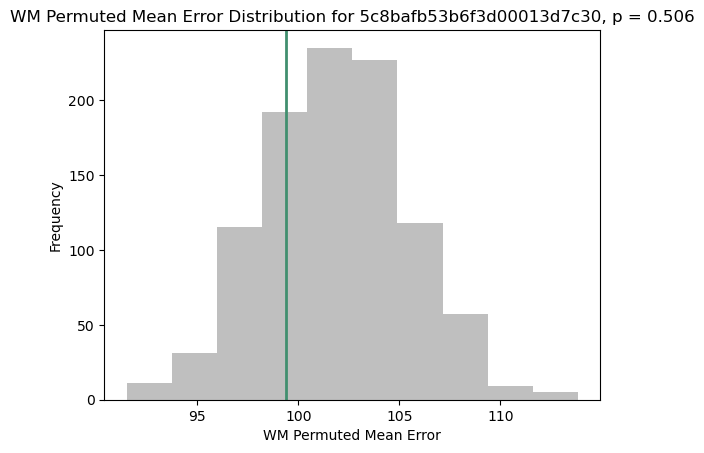

WM, 5f21c29511084913913af654: p = 0.000
WM, 5d453e8723a5bb0001492546: p = 0.000
WM, 5f7014ba8655415e9dddc1b7: p = 0.000
WM, 5f06eefaf3fc742667b4e79d: p = 0.118


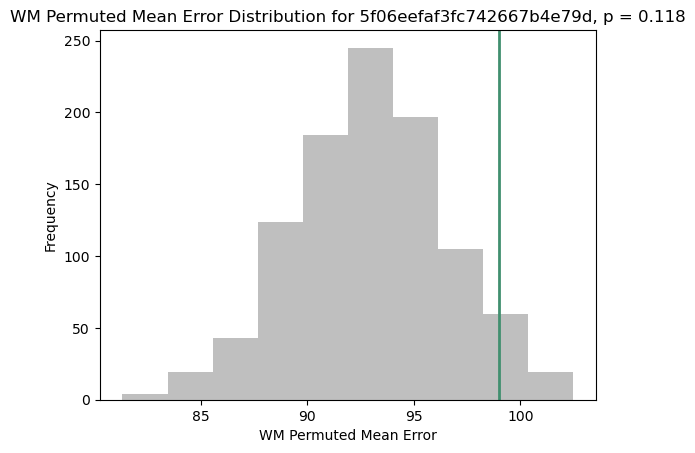

WM, 651eda4af4a809dbba0bb002: p = 0.000
WM, 658405e29e9aac7350cdb75a: p = 0.018
WM, 60bbc368a316ee5421a1153b: p = 0.038
WM, 5d49d17b3dad1f0001e2aba1: p = 0.110


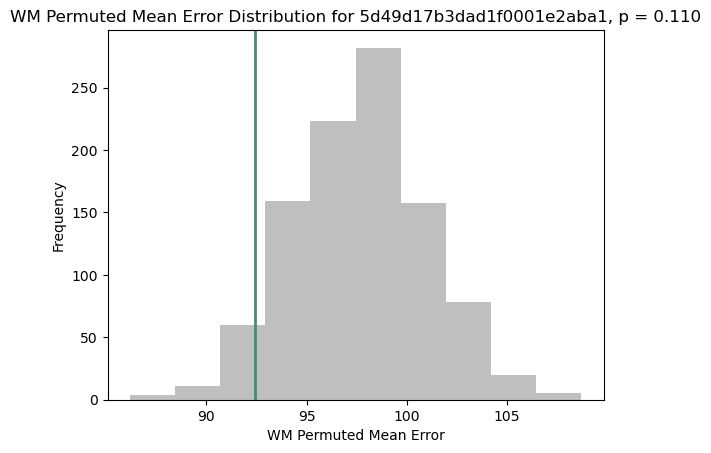

WM, 5ed8cf4782a6eb04ddf9962d: p = 0.000
WM, 5edab6df83998915303516d5: p = 0.000
WM, 65e2b3b946ad361e29ccd504: p = 0.000
WM, 5d6e3252dfe6d10001dbe508: p = 0.000
WM, 607ec7379eac7be04ab448e3: p = 0.002
WM, 596634e005f2df00017281ae: p = 0.000
WM, 64a9c85cd18d2853ec8eca4d: p = 0.394


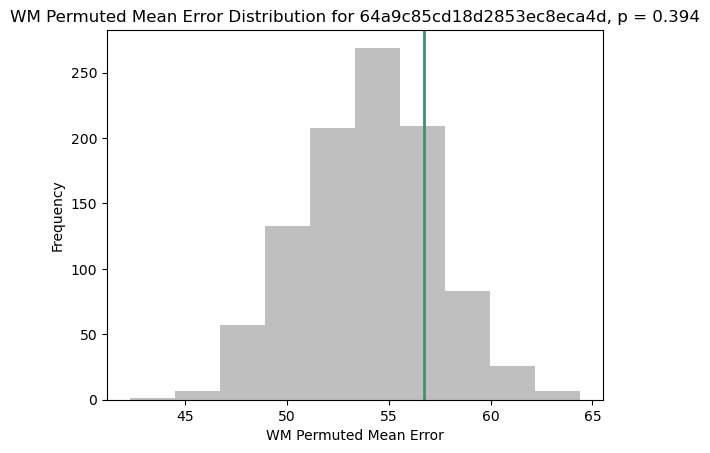

WM, 5f63a2bc08a0080c790f8eb6: p = 0.000
WM, 65aa815acfeb858f15d2cf29: p = 0.206


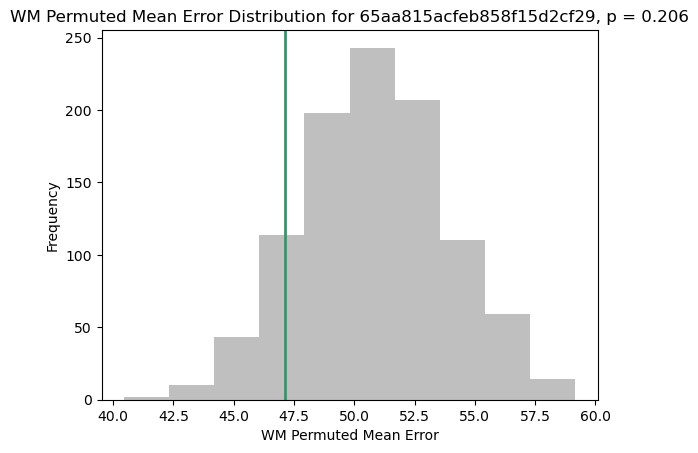

WM, 60bf964f35e4cada9f7f03cc: p = 0.022
WM, 63ea4564de250efaacb1cceb: p = 0.192


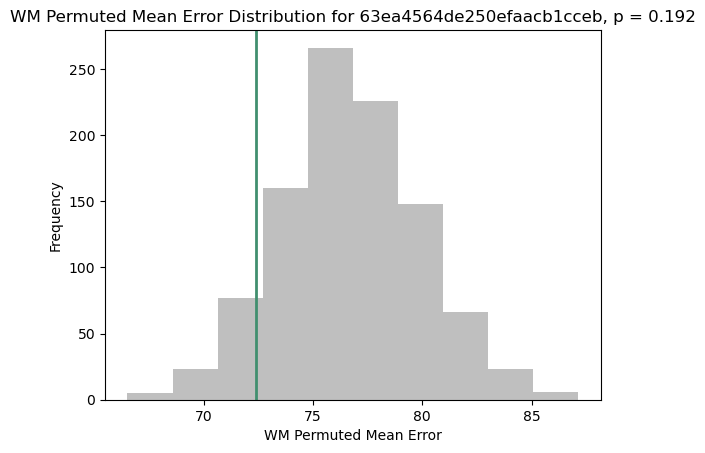

WM, 60f5b42174aa93c2c1522ecf: p = 0.000
WM, 5df5143f58a5c738d0e197af: p = 0.000
WM, 5fc9ec3d0990d4501dfd7e05: p = 0.000
WM, 65a2a4643cc27e9702199c43: p = 0.252


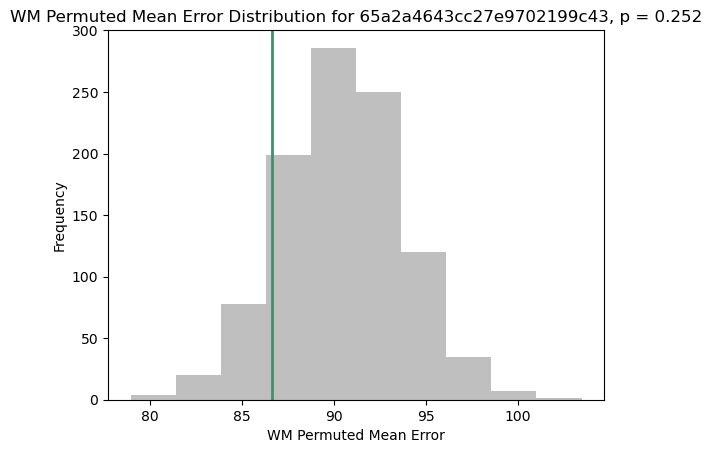

WM, 60f814d5348f2f80c0e60c3a: p = 0.000
WM, 5e4949035607633bb4759ffe: p = 0.082


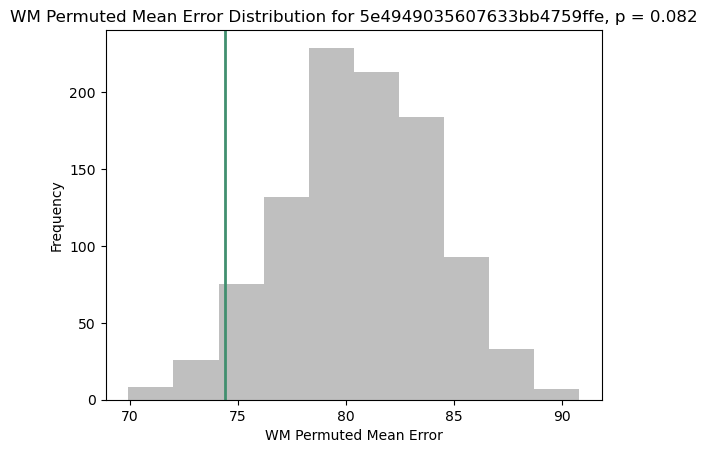

WM, 604b2da4f24a3d7a227553a0: p = 0.000
WM, 63474e67a5fd298c6103c409: p = 0.056


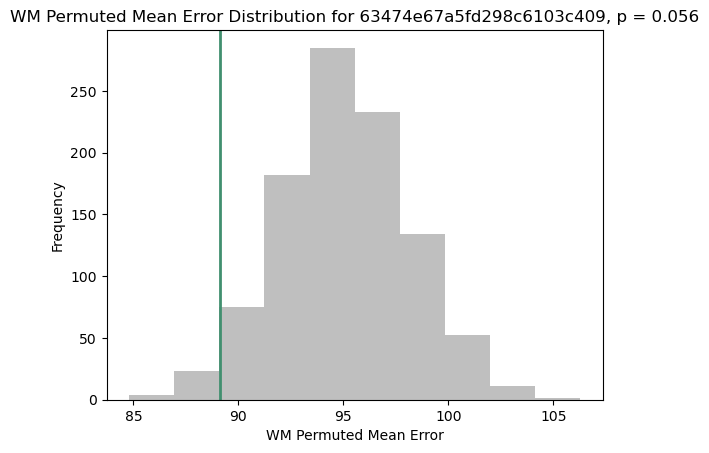

WM, 614775c6f329a9e5ab190e04: p = 0.000
WM, 5e2edcd3744c694aa3fab543: p = 0.000
WM, 606e2c6d64e3ba353fb68bd5: p = 0.000
WM, 60561bed5ea5ad8dbe3fae07: p = 0.000
WM, 61636a4bf1a773cc305502e7: p = 0.000
WM, 6557ecc93cc84dd3699e608c: p = 0.000
WM, 5baf6705848bbd0001d6fc8a: p = 0.824


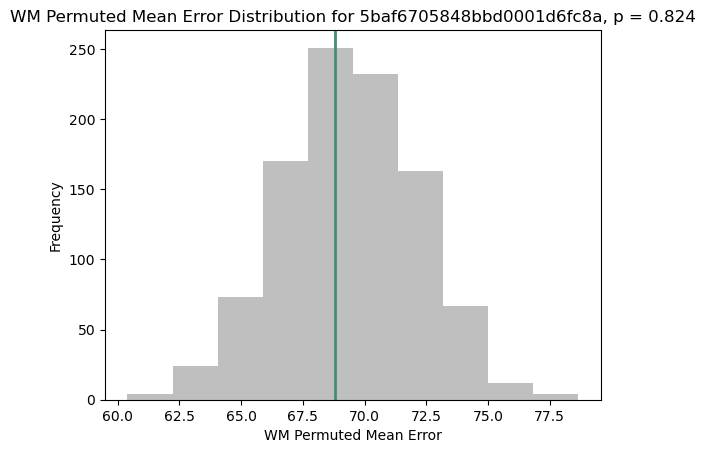

WM, 6507b0bf6c158dca2bfde795: p = 0.148


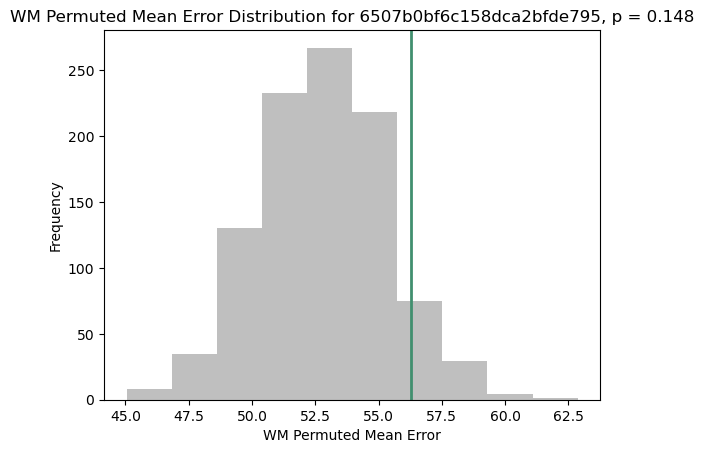

WM, 5b305b176d601d0001d5ea96: p = 0.784


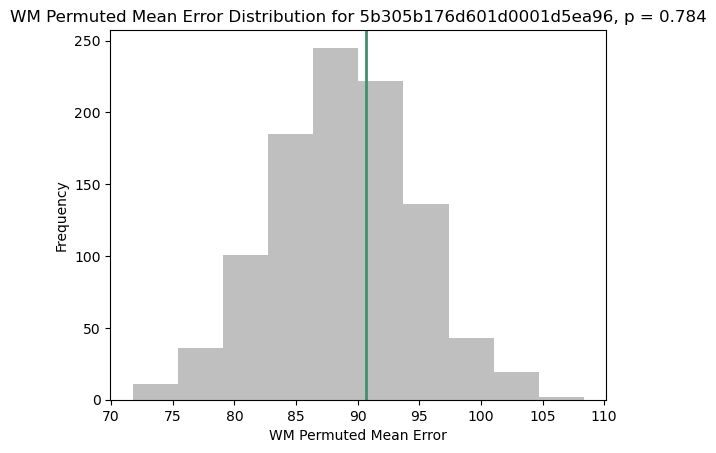

WM, 5f0214e58782120a8c970fd6: p = 0.000
WM, 5f1b2fe23bcef80c38d2a362: p = 0.000
WM, 5f2df57e756b8414ea47017f: p = 0.000
WM, 6511f1f1490c9df9f8c7890e: p = 0.000
WM, 5ef308c7177aaa011e808579: p = 0.000
WM, 5c5baaec192d350001d5c8e4: p = 0.000
WM, 5fbfe145e52a44000a9c2966: p = 0.022
WM, 602bcbe610c7c138a909e6e4: p = 0.000
WM, 5a2adf6a8e00a000019864fb: p = 0.038
WM, 64483a04905bcd4a0e0b21e7: p = 0.000
WM, 64e90980b61f9d9b18570af5: p = 0.024
WM, 5dfe7de0bf3d4eb1cc979a7a: p = 0.288


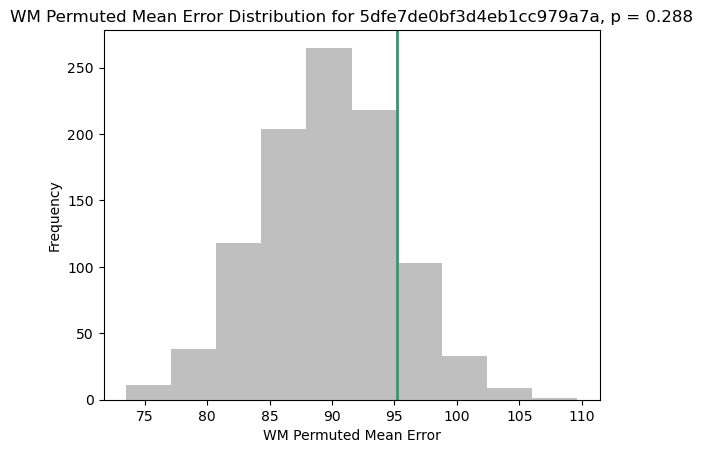

WM, 62eac88dc8087b43cdf64480: p = 0.000
WM, 5faeb56b25a37f01d47d326c: p = 0.000
WM, 5bc880109f7801000148601b: p = 0.000
WM, 5fb6ed2116919c000a99249e: p = 0.100


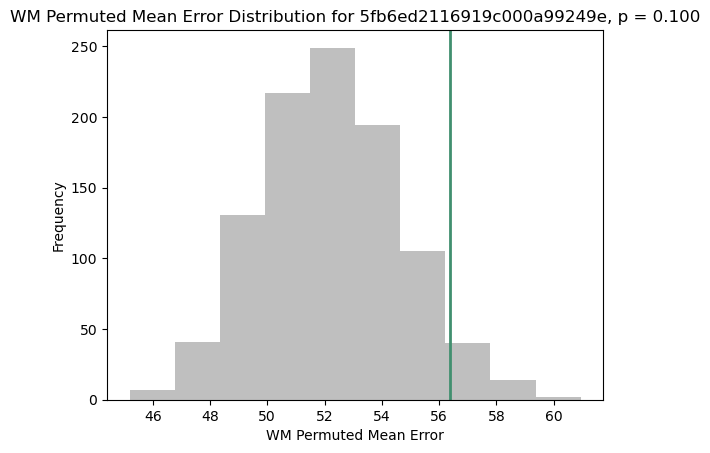

WM, 65ae78fc9cd81e8e26612cb2: p = 0.326


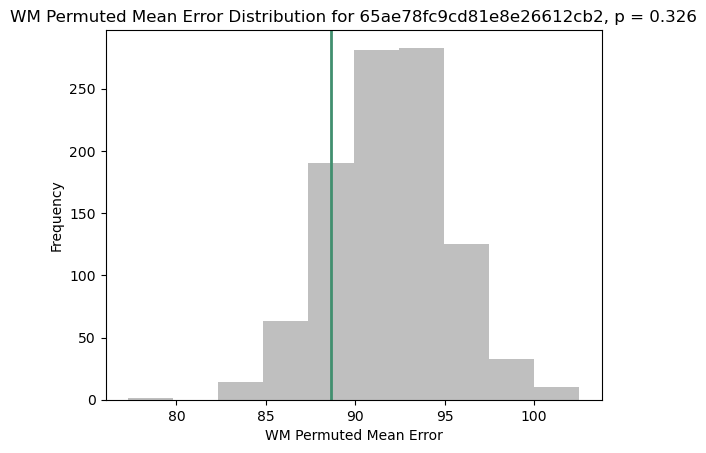

WM, 61570d5eb2963a6d6ea3719a: p = 0.500


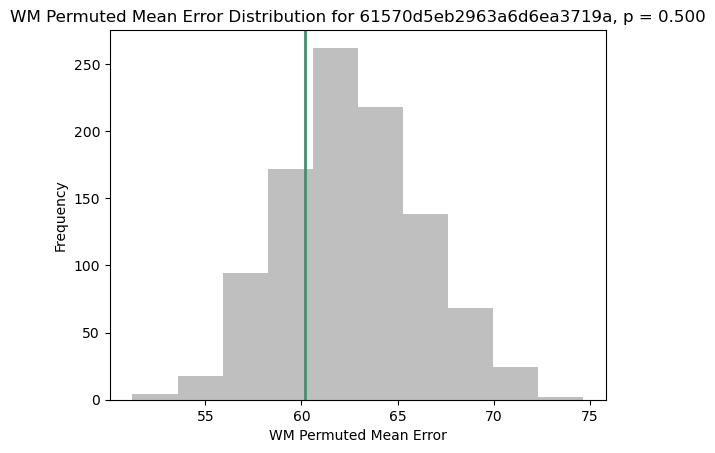

WM, 61267b828ead584bcf092e35: p = 0.000
WM, 65009151ae76614bc29c63c5: p = 0.374


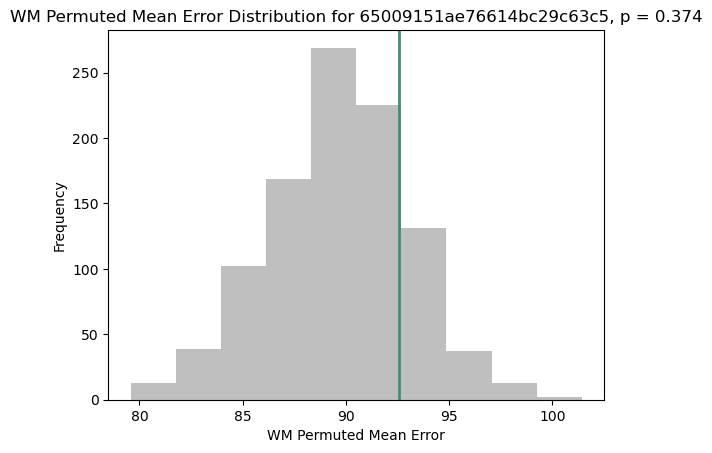

WM, 5fc964a6f1bba642e52124f3: p = 0.000
WM, 60f874f29a003c1fd595ba46: p = 0.000
WM, 6560ae7968dae6508fe4d420: p = 0.000
WM, 5f87993abcee241dace4a140: p = 0.182


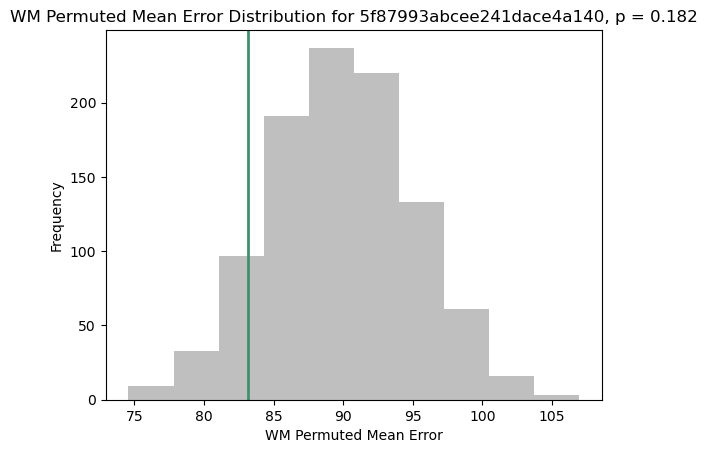

WM, 613b08149aaccb2ae9fb88c6: p = 0.000
WM, 564e93659b124900127eb55b: p = 0.000
WM, 653e1d568239743665fadd23: p = 0.000
WM, 604b169fe4b7991ec08da3a6: p = 0.000
WM, 63be3c7ab7bccecc7dc80cd4: p = 0.396


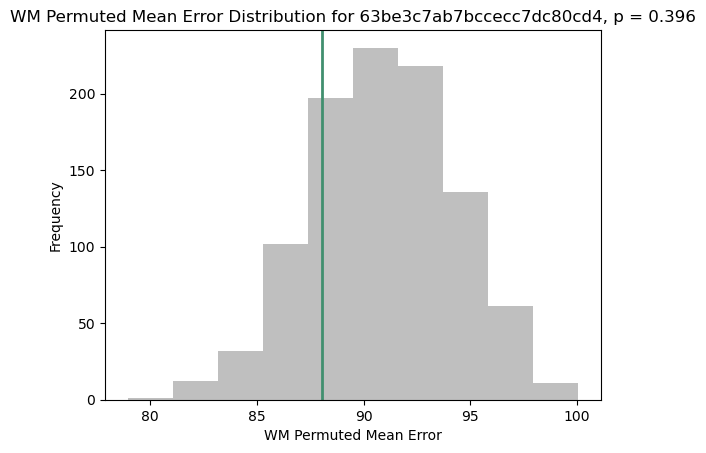

WM, 5c70974403f85b0001af8d5d: p = 0.000
WM, 5f0f7fe1d7ad1c000b42d091: p = 0.034
WM, 5c41f9ce4fe4f800016dfaac: p = 0.000
WM, 60dc664ea12f7f477dbc4d9d: p = 0.148


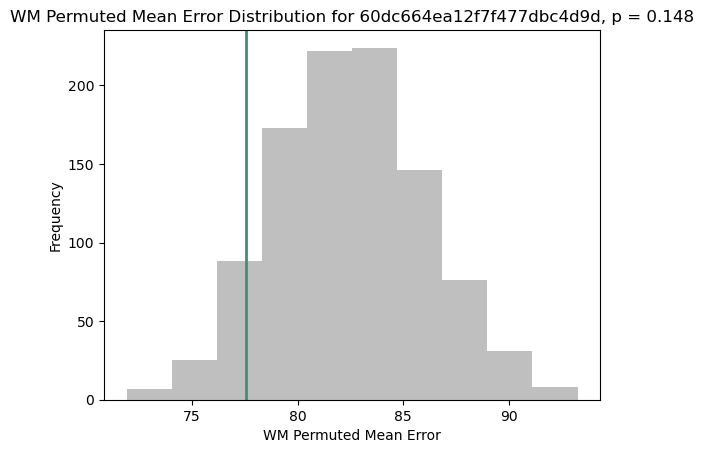

WM, 5f9dbfe05e108133385603fd: p = 0.000
WM, 660dc402b15789026445073d: p = 0.000
WM, 60aea3068c18c4a83c630833: p = 0.086


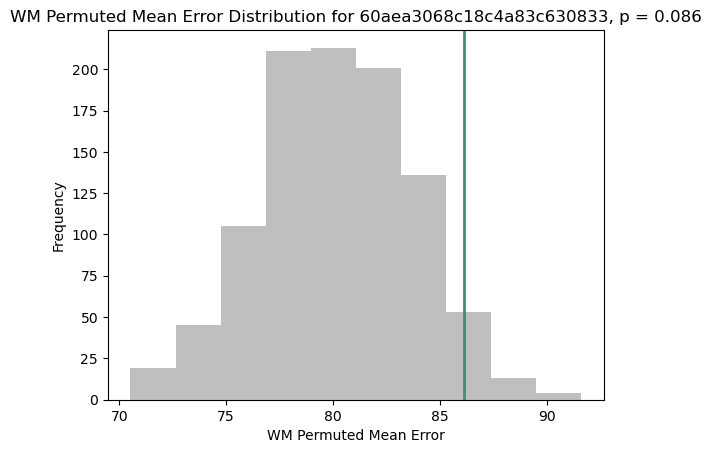

WM, 65ec07509e72647fd829ccdb: p = 0.000
WM, 5cbe04b4f429ff00159de30e: p = 0.416


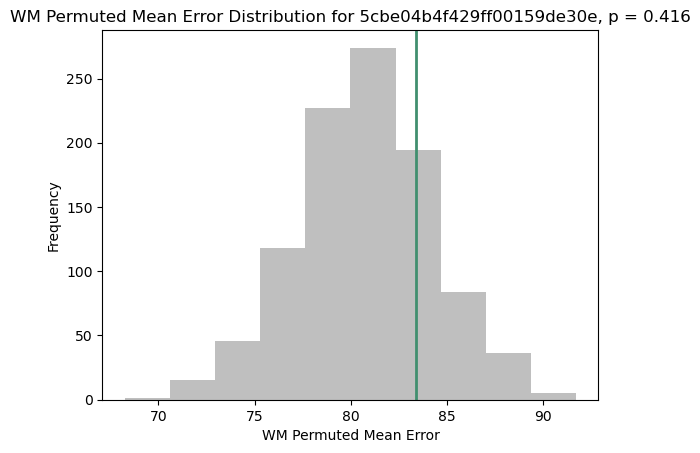

WM, 5e7a5584718c83035a42519c: p = 0.000
WM, 6529425c8642a206285c998b: p = 0.696


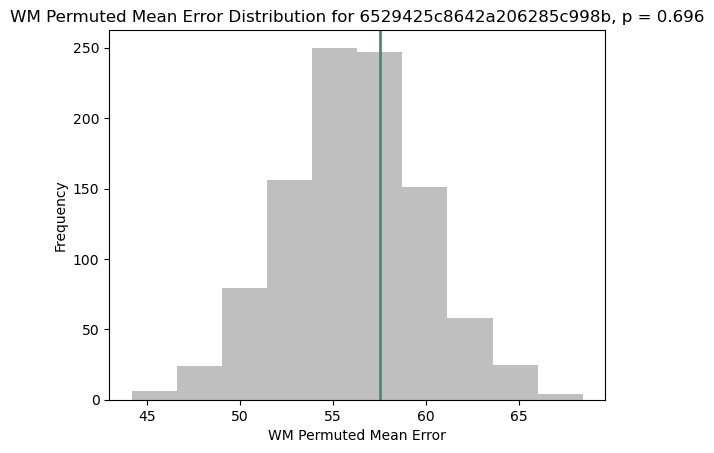

WM, 5f0eaf80c42b540711cc68b0: p = 0.698


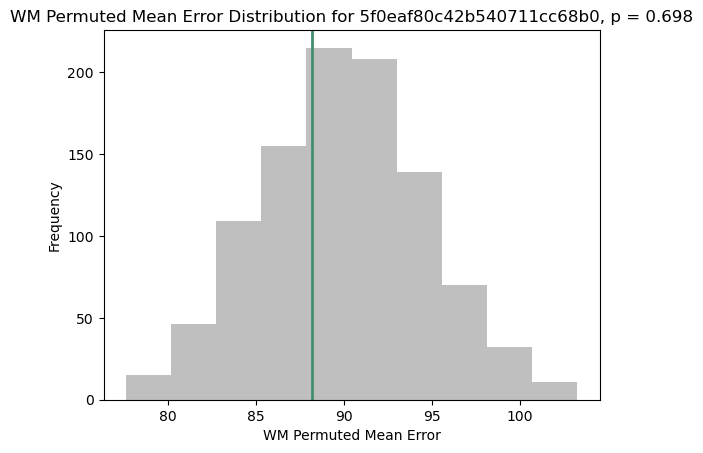

WM, 5c05cfad84b02d0001155d3e: p = 0.000
WM, 5f108dea719866356702d26f: p = 0.012
WM, 6511e9adc4ba37678f5f1181: p = 0.000
WM, 5fd7782dee03dc08d3f3f491: p = 0.000
WM, 5e6f91fe74ff43011dd127ec: p = 0.000
WM, 5e5c993cd0394c474f7cc502: p = 0.000
WM, 59d4c100078dbe0001951236: p = 0.008
WM, 65cf6d92ac6f7932b1470fb4: p = 0.000
WM, 6067dddcfd845322c6dddae6: p = 0.000
WM, 5eac4b0a1f8db726fc6060c8: p = 0.000
WM, 6505ac055ce097f5c35a4760: p = 0.000
WM, 61413300c9d2346cfb3d9ca5: p = 0.000
WM, 5b74413e722bd2000195c067: p = 0.092


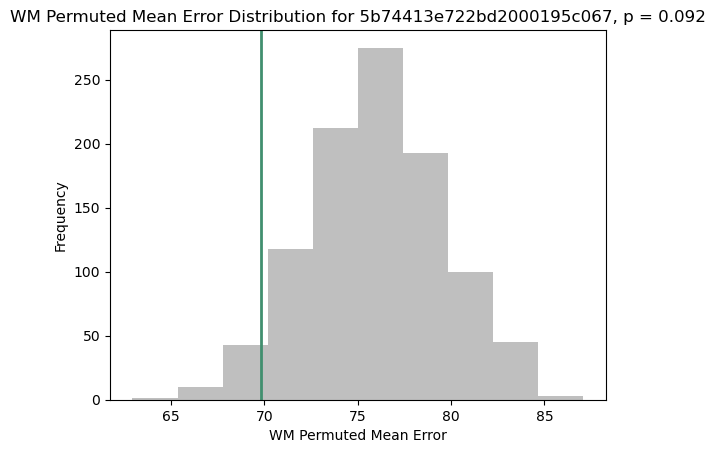

WM, 65a59ec6ce36c09b7a3a8e70: p = 0.000
WM, 5ddb84c67af661ad594e95d4: p = 0.000
WM, 612537b2bd6b4a38f4e7f63a: p = 0.882


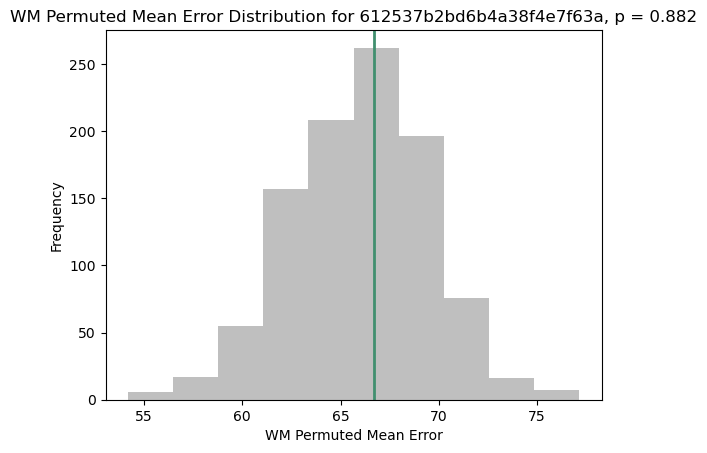

WM, 6527e40a8a1bf0c1ad98cdd3: p = 0.000
WM, 5f7f239e9b204e05b6c36538: p = 0.000
WM, 60c9f83c9e07879a1ca4ae3a: p = 0.000
WM, 5b0c1fdebd9c3100015641ae: p = 0.494


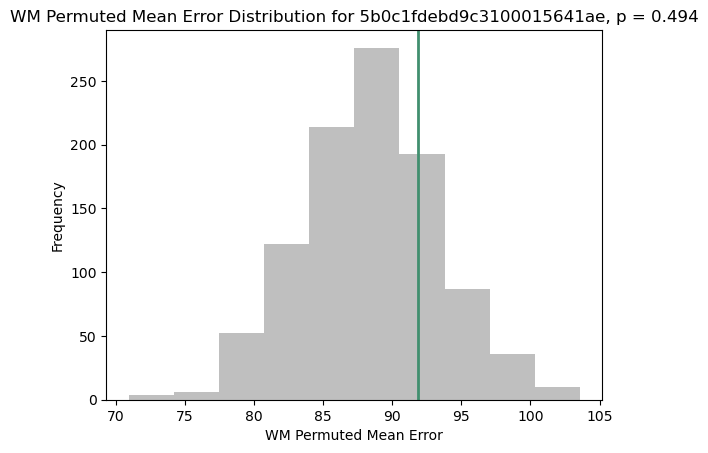

WM, 609bfd97a7c95881330491d4: p = 0.000
WM, 605a2dbead400eae8de18f8c: p = 0.470


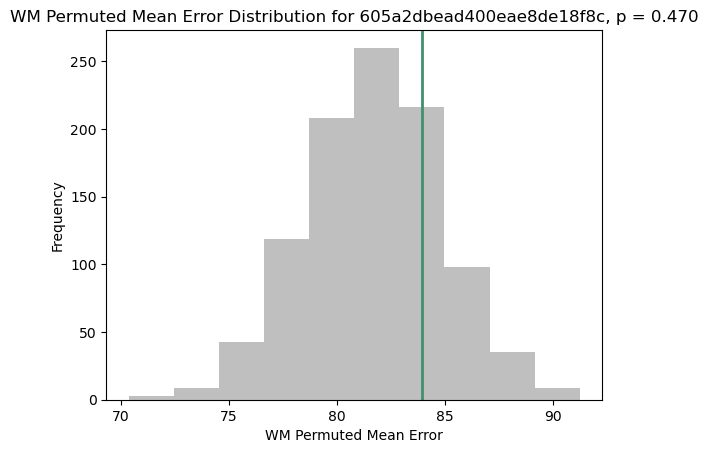

WM, 5fe3792db939ed02b8c1d0f8: p = 0.000
WM, 5e8a5a892f6f027054a83d88: p = 0.000
WM, 656013477ede6fae3cc2728b: p = 0.000
WM, 60ef2e52a188d9859f92bb58: p = 0.302


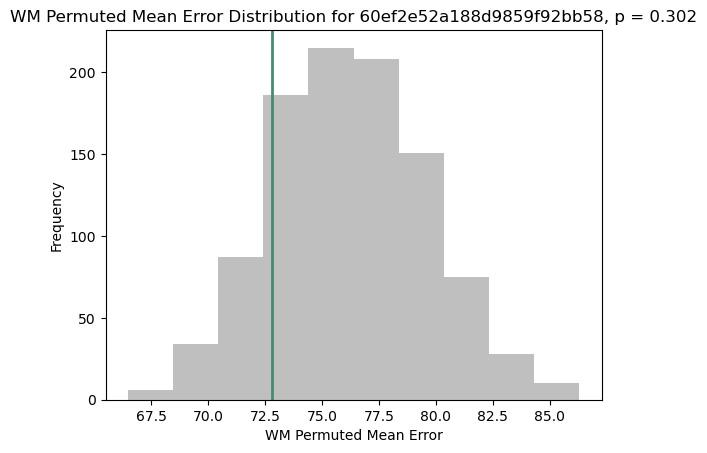

WM, 654afb2d87012840100daf23: p = 0.000
WM, 5608a73fd7def20012b7389d: p = 0.000
WM, 5e1f7b2a4c9b832b34e7c9d3: p = 0.000
WM, 65c0f99b71fb575465c6ca0d: p = 0.846


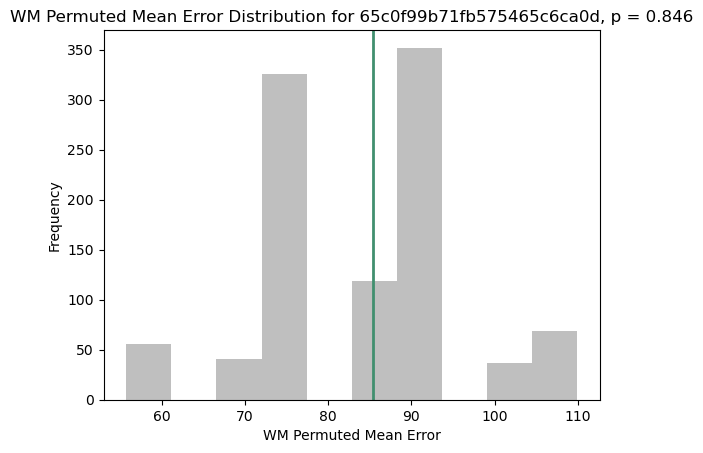

WM, 65a9346ad1f231c46618a067: p = 0.350


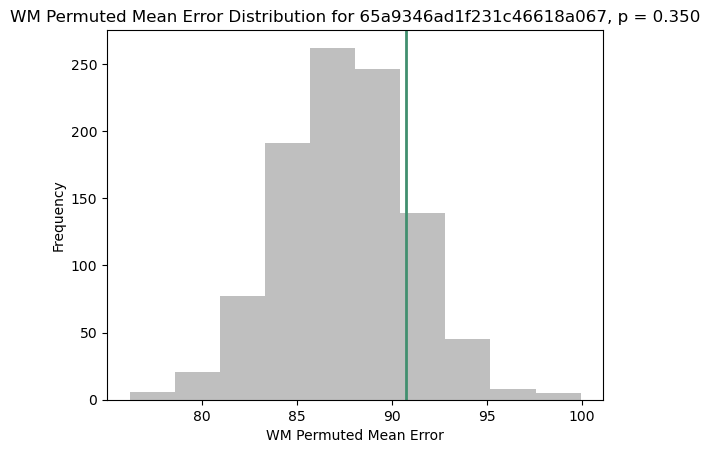

WM, 65745708518a6ec1b4773387: p = 0.000
WM, 545d347afdf99b7f9fca22c7: p = 0.000
WM, 5cc618c53c503e0001a61a63: p = 0.028
WM, 561487ad7ffc8a0012812266: p = 0.000
WM, 5c60c298af517e0001a00b00: p = 0.000
WM, 607893faf75b80c8b2a14613: p = 0.000
WM, 657fbbe828dfa7fbd9a169b6: p = 0.434


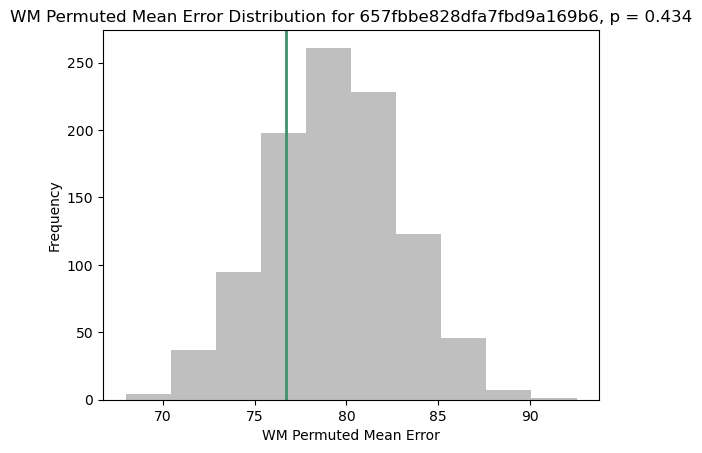

WM, 60f679ef8bc07769a1af64e4: p = 0.038
WM, 63ffcb367b500c516d0648a2: p = 0.802


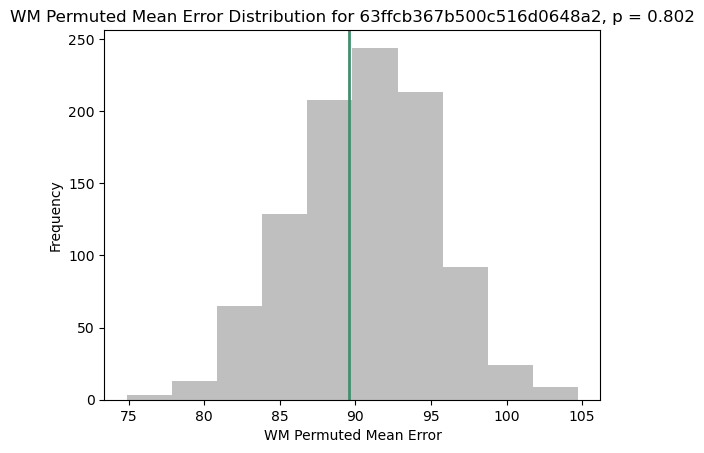

WM, 650222d04fe305c48c9a98ee: p = 0.000
LTM, 5c8bafb53b6f3d00013d7c30: p = 0.054


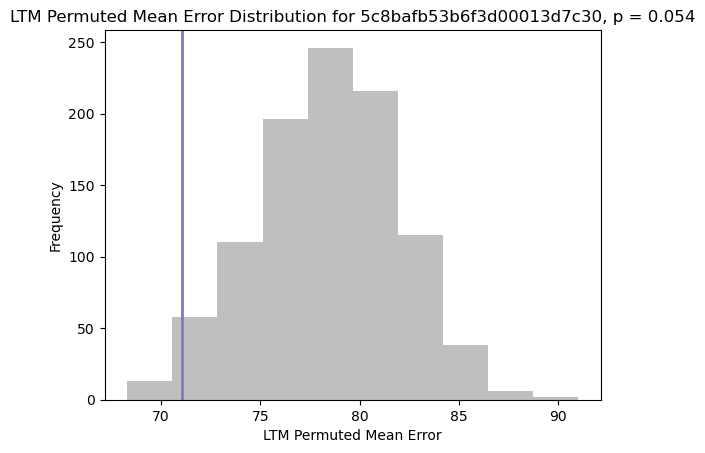

LTM, 5f21c29511084913913af654: p = 0.000
LTM, 5d453e8723a5bb0001492546: p = 0.000
LTM, 5f7014ba8655415e9dddc1b7: p = 0.000
LTM, 5f06eefaf3fc742667b4e79d: p = 0.008
LTM, 651eda4af4a809dbba0bb002: p = 0.000
LTM, 658405e29e9aac7350cdb75a: p = 0.000
LTM, 60bbc368a316ee5421a1153b: p = 0.000
LTM, 5d49d17b3dad1f0001e2aba1: p = 0.520


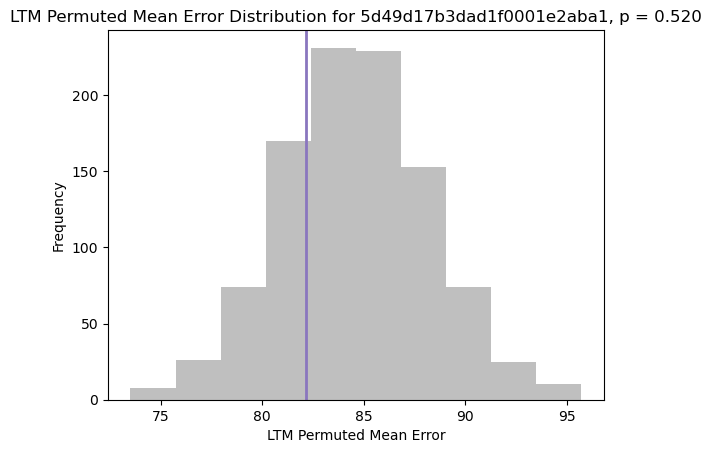

LTM, 5ed8cf4782a6eb04ddf9962d: p = 0.000
LTM, 5edab6df83998915303516d5: p = 0.000
LTM, 65e2b3b946ad361e29ccd504: p = 0.000
LTM, 5d6e3252dfe6d10001dbe508: p = 0.000
LTM, 607ec7379eac7be04ab448e3: p = 0.000
LTM, 596634e005f2df00017281ae: p = 0.000
LTM, 64a9c85cd18d2853ec8eca4d: p = 0.742


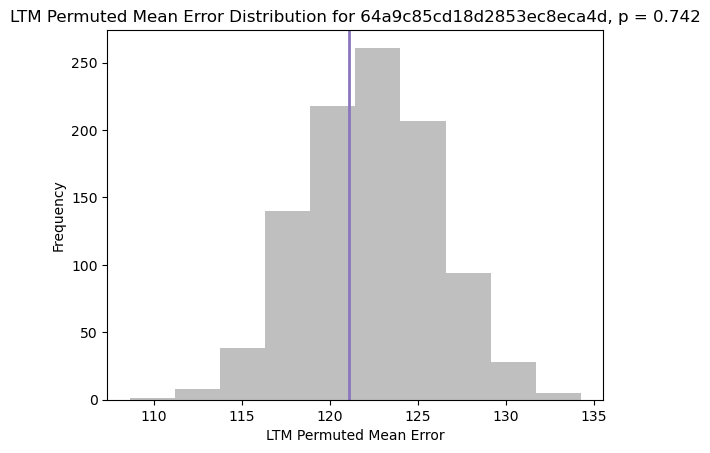

LTM, 5f63a2bc08a0080c790f8eb6: p = 0.000
LTM, 65aa815acfeb858f15d2cf29: p = 0.000
LTM, 60bf964f35e4cada9f7f03cc: p = 0.064


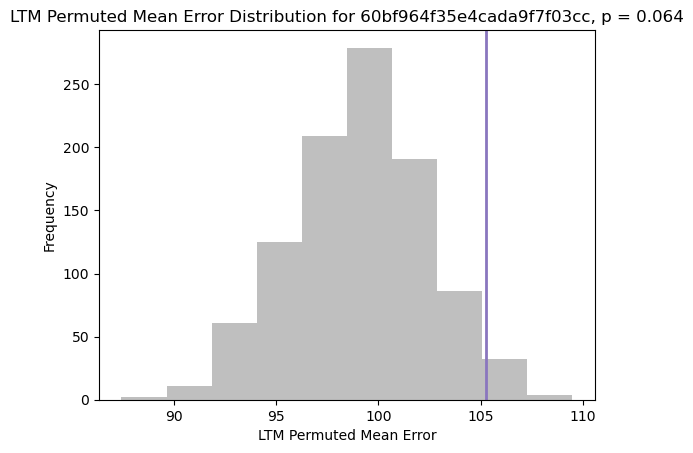

LTM, 63ea4564de250efaacb1cceb: p = 0.204


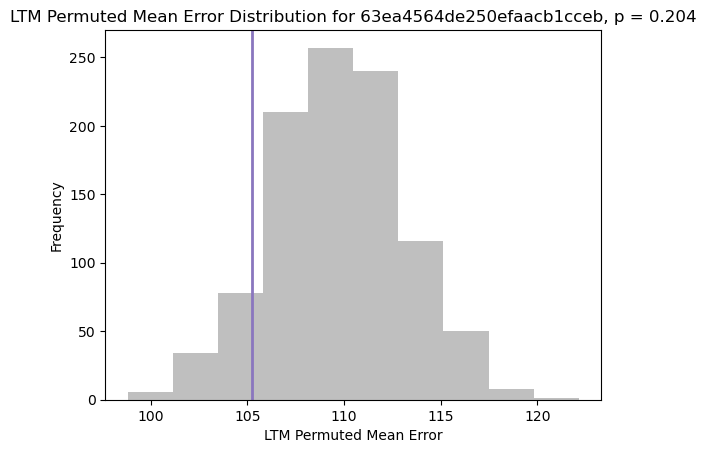

LTM, 60f5b42174aa93c2c1522ecf: p = 0.000
LTM, 5df5143f58a5c738d0e197af: p = 0.894


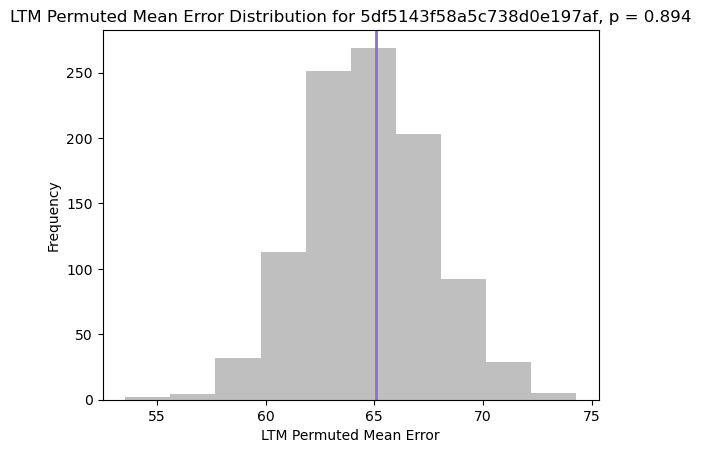

LTM, 5fc9ec3d0990d4501dfd7e05: p = 0.000
LTM, 65a2a4643cc27e9702199c43: p = 0.194


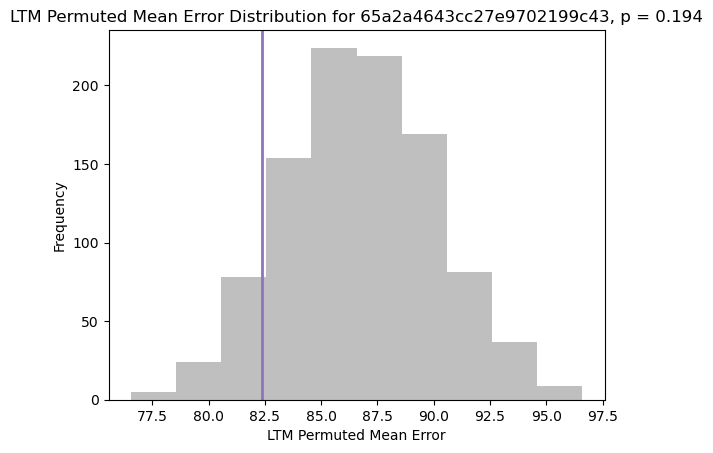

LTM, 60f814d5348f2f80c0e60c3a: p = 0.000
LTM, 5e4949035607633bb4759ffe: p = 0.138


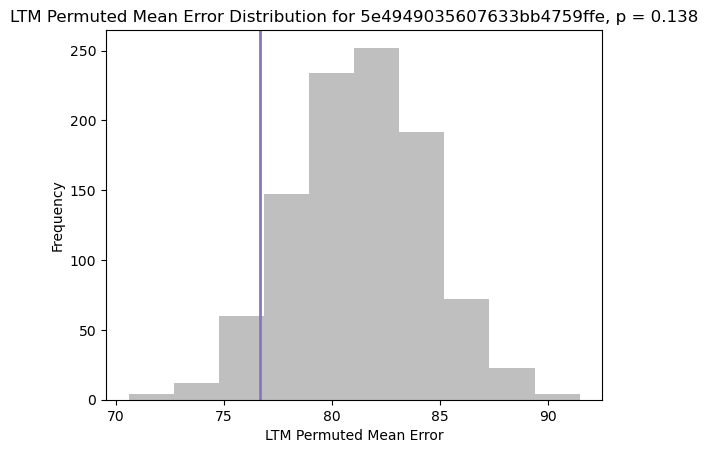

LTM, 604b2da4f24a3d7a227553a0: p = 0.000
LTM, 63474e67a5fd298c6103c409: p = 0.000
LTM, 614775c6f329a9e5ab190e04: p = 0.000
LTM, 5e2edcd3744c694aa3fab543: p = 0.000
LTM, 606e2c6d64e3ba353fb68bd5: p = 0.000
LTM, 60561bed5ea5ad8dbe3fae07: p = 0.000
LTM, 61636a4bf1a773cc305502e7: p = 0.000
LTM, 6557ecc93cc84dd3699e608c: p = 0.000
LTM, 5baf6705848bbd0001d6fc8a: p = 0.000
LTM, 6507b0bf6c158dca2bfde795: p = 0.000
LTM, 5b305b176d601d0001d5ea96: p = 0.520


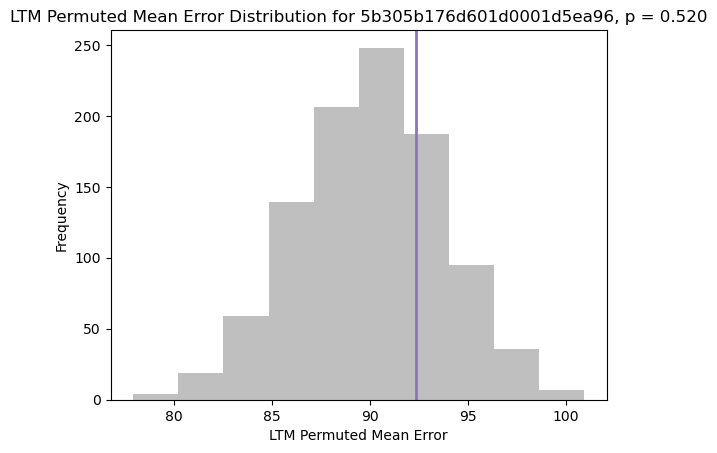

LTM, 5f0214e58782120a8c970fd6: p = 0.000
LTM, 5f1b2fe23bcef80c38d2a362: p = 0.000
LTM, 5f2df57e756b8414ea47017f: p = 0.000
LTM, 6511f1f1490c9df9f8c7890e: p = 0.630


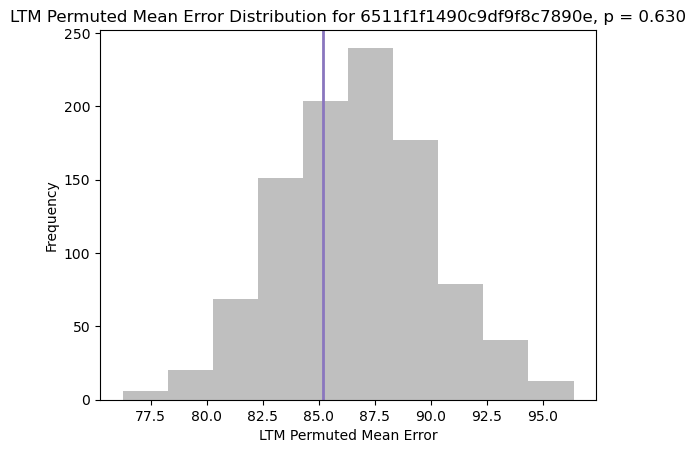

LTM, 5ef308c7177aaa011e808579: p = 0.000
LTM, 5c5baaec192d350001d5c8e4: p = 0.000
LTM, 5fbfe145e52a44000a9c2966: p = 0.000
LTM, 602bcbe610c7c138a909e6e4: p = 0.000
LTM, 5a2adf6a8e00a000019864fb: p = 0.000
LTM, 64483a04905bcd4a0e0b21e7: p = 0.000
LTM, 64e90980b61f9d9b18570af5: p = 0.934


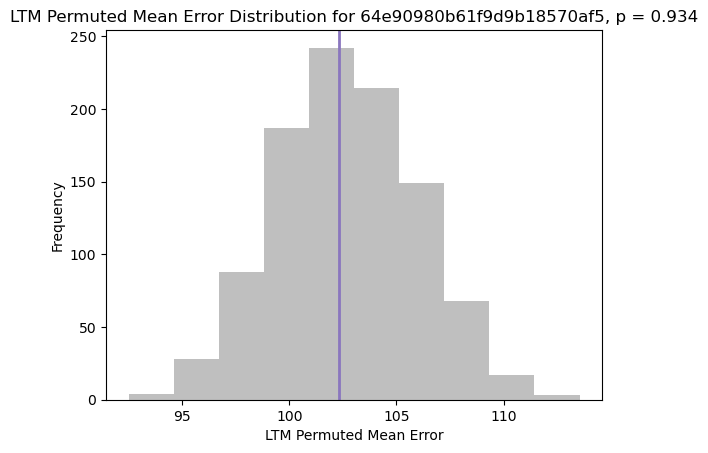

LTM, 5dfe7de0bf3d4eb1cc979a7a: p = 0.906


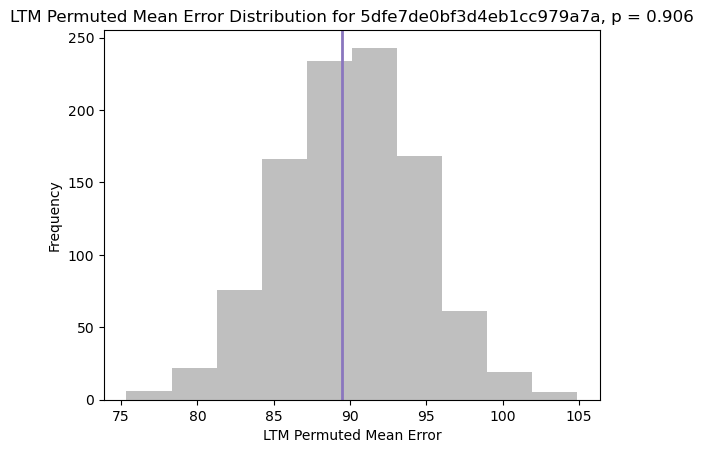

LTM, 62eac88dc8087b43cdf64480: p = 0.000
LTM, 5faeb56b25a37f01d47d326c: p = 0.000
LTM, 5bc880109f7801000148601b: p = 0.000
LTM, 5fb6ed2116919c000a99249e: p = 0.000
LTM, 65ae78fc9cd81e8e26612cb2: p = 0.904


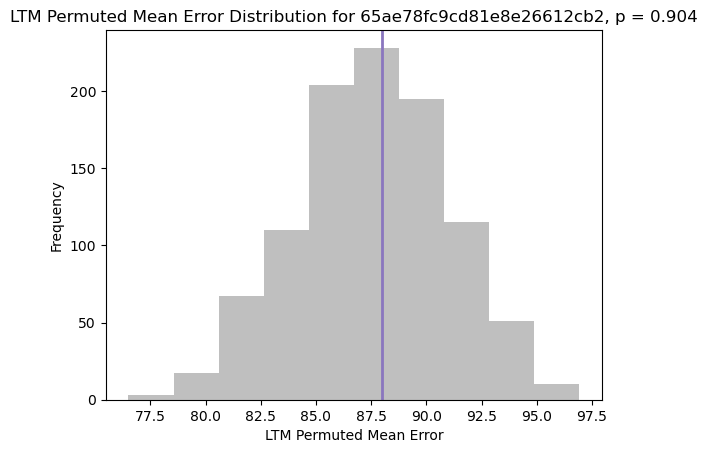

LTM, 61570d5eb2963a6d6ea3719a: p = 0.000
LTM, 61267b828ead584bcf092e35: p = 0.000
LTM, 65009151ae76614bc29c63c5: p = 0.634


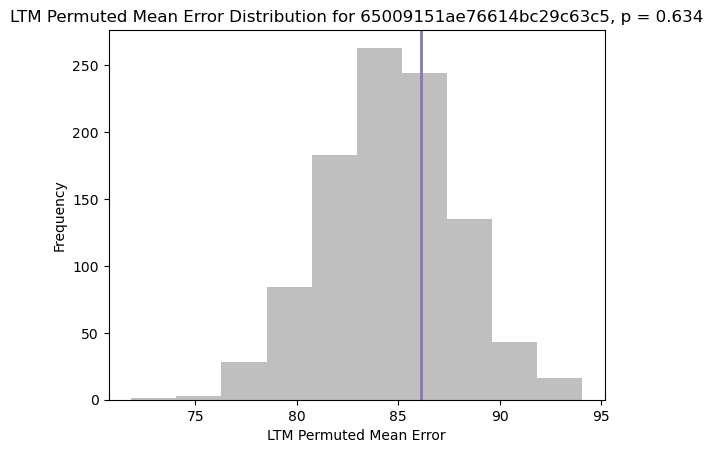

LTM, 5fc964a6f1bba642e52124f3: p = 0.000
LTM, 60f874f29a003c1fd595ba46: p = 0.000
LTM, 6560ae7968dae6508fe4d420: p = 0.000
LTM, 5f87993abcee241dace4a140: p = 0.252


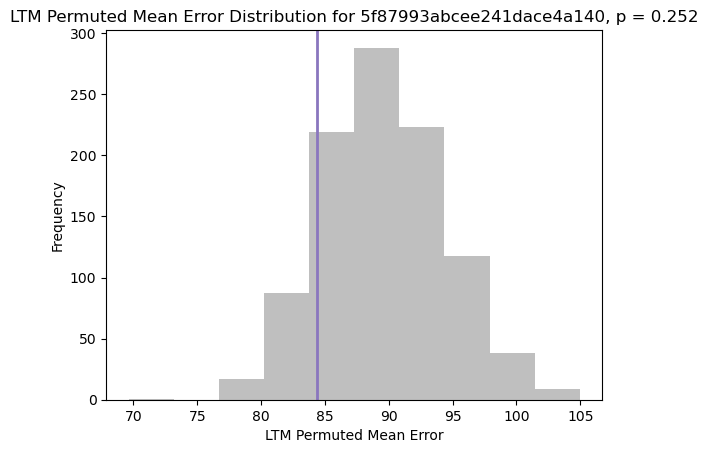

LTM, 613b08149aaccb2ae9fb88c6: p = 0.000
LTM, 564e93659b124900127eb55b: p = 0.000
LTM, 653e1d568239743665fadd23: p = 0.000
LTM, 604b169fe4b7991ec08da3a6: p = 0.534


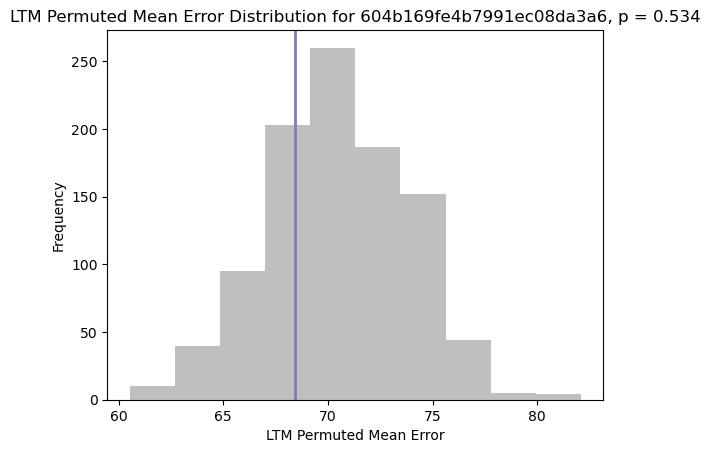

LTM, 63be3c7ab7bccecc7dc80cd4: p = 0.094


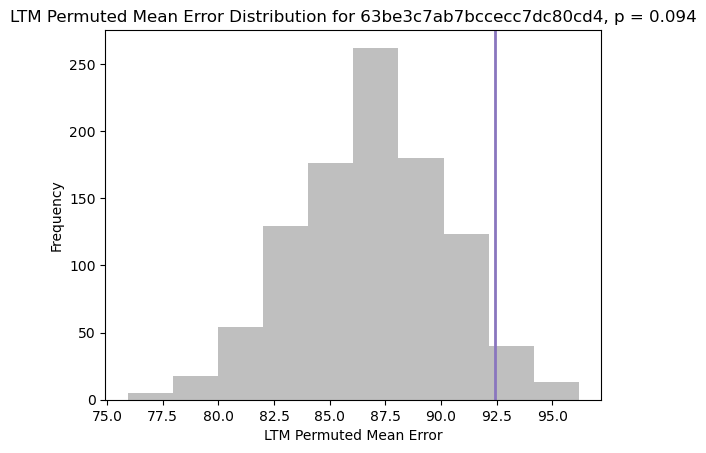

LTM, 5c70974403f85b0001af8d5d: p = 0.000
LTM, 5f0f7fe1d7ad1c000b42d091: p = 0.498


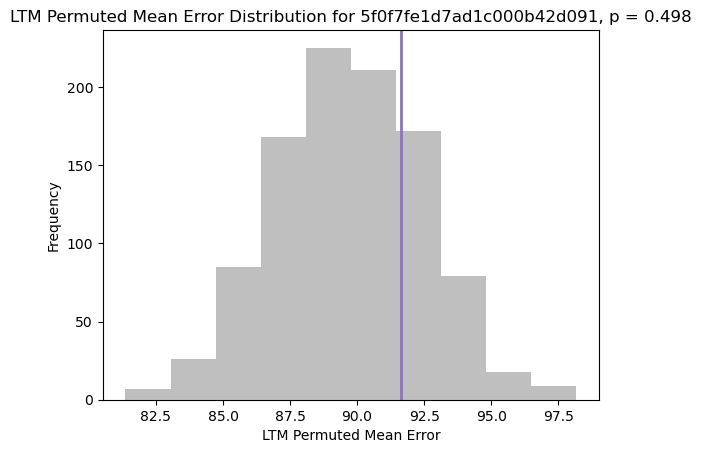

LTM, 5c41f9ce4fe4f800016dfaac: p = 0.000
LTM, 60dc664ea12f7f477dbc4d9d: p = 0.424


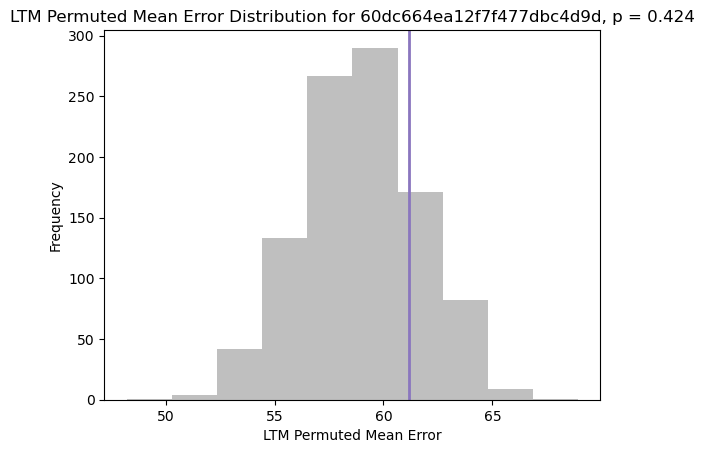

LTM, 5f9dbfe05e108133385603fd: p = 0.000
LTM, 660dc402b15789026445073d: p = 0.000
LTM, 60aea3068c18c4a83c630833: p = 0.714


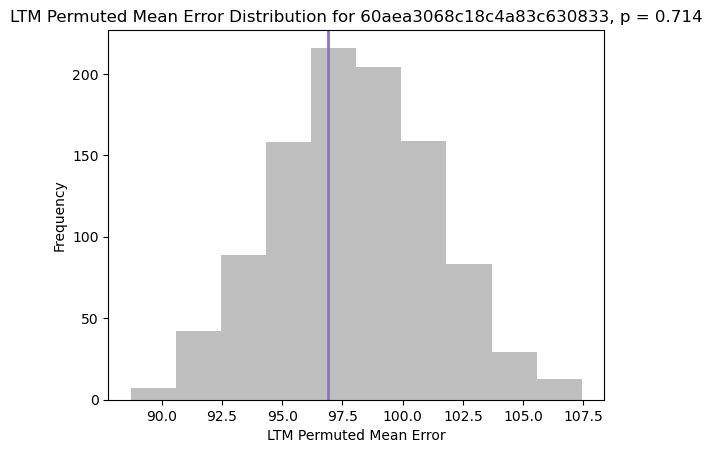

LTM, 65ec07509e72647fd829ccdb: p = 0.016
LTM, 5cbe04b4f429ff00159de30e: p = 0.370


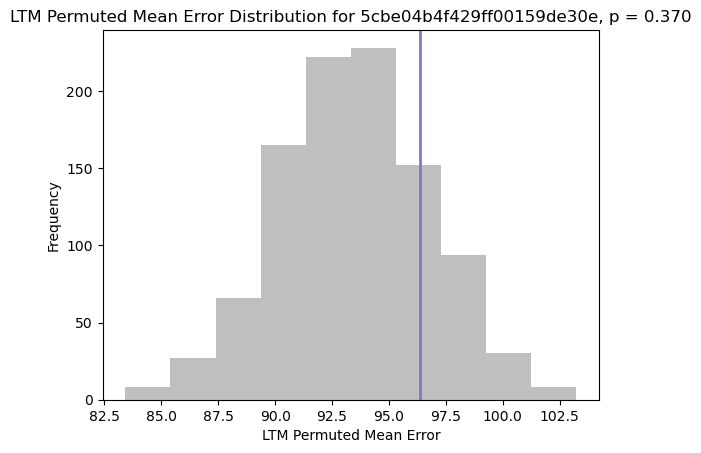

LTM, 5e7a5584718c83035a42519c: p = 0.000
LTM, 6529425c8642a206285c998b: p = 0.268


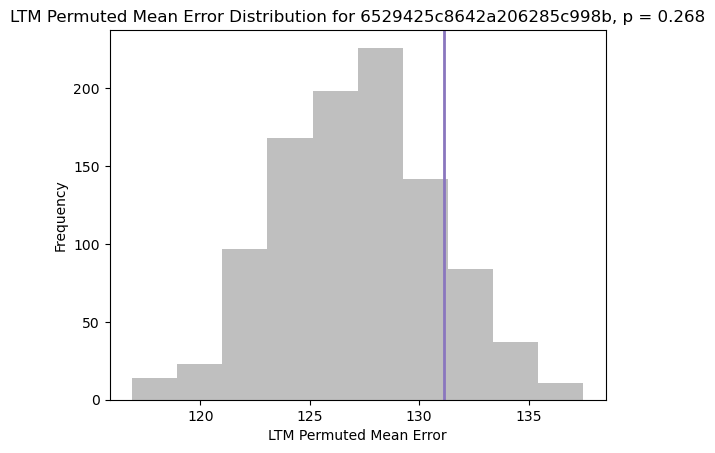

LTM, 5f0eaf80c42b540711cc68b0: p = 0.172


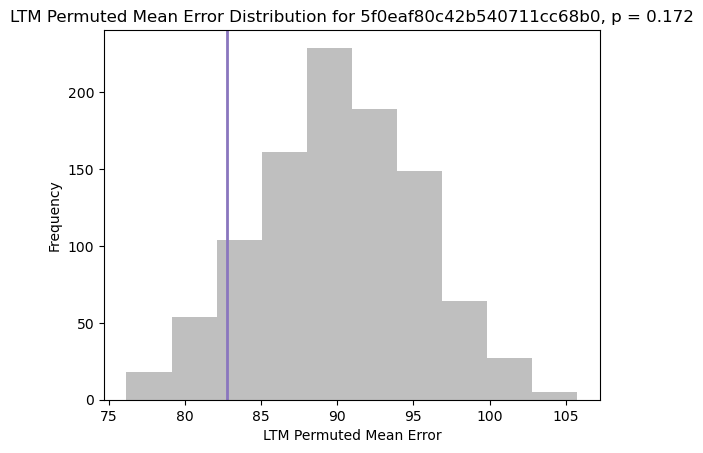

LTM, 5c05cfad84b02d0001155d3e: p = 0.000
LTM, 5f108dea719866356702d26f: p = 0.000
LTM, 6511e9adc4ba37678f5f1181: p = 0.000
LTM, 5fd7782dee03dc08d3f3f491: p = 0.000
LTM, 5e6f91fe74ff43011dd127ec: p = 0.000
LTM, 5e5c993cd0394c474f7cc502: p = 0.000
LTM, 59d4c100078dbe0001951236: p = 0.000
LTM, 65cf6d92ac6f7932b1470fb4: p = 0.000
LTM, 6067dddcfd845322c6dddae6: p = 0.000
LTM, 5eac4b0a1f8db726fc6060c8: p = 0.000
LTM, 6505ac055ce097f5c35a4760: p = 0.000
LTM, 61413300c9d2346cfb3d9ca5: p = 0.000
LTM, 5b74413e722bd2000195c067: p = 0.304


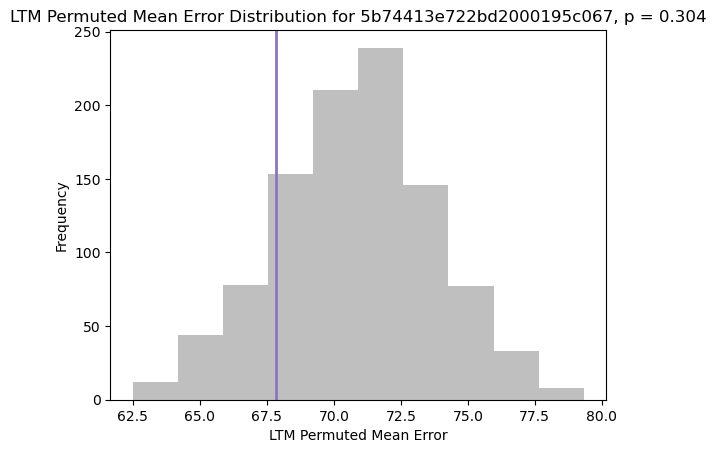

LTM, 65a59ec6ce36c09b7a3a8e70: p = 0.000
LTM, 5ddb84c67af661ad594e95d4: p = 0.664


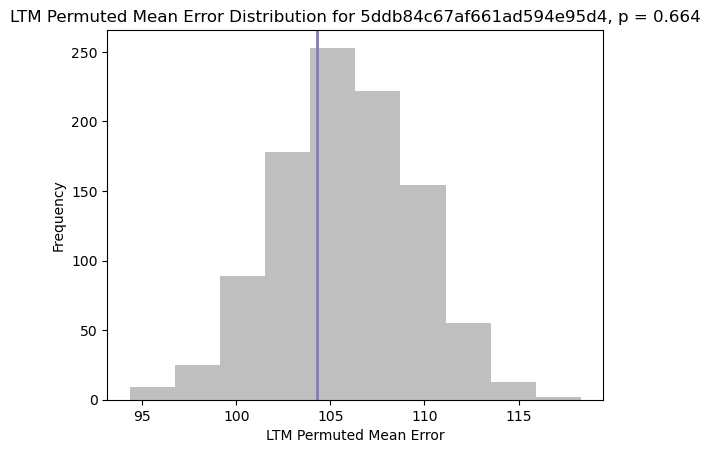

LTM, 612537b2bd6b4a38f4e7f63a: p = 0.472


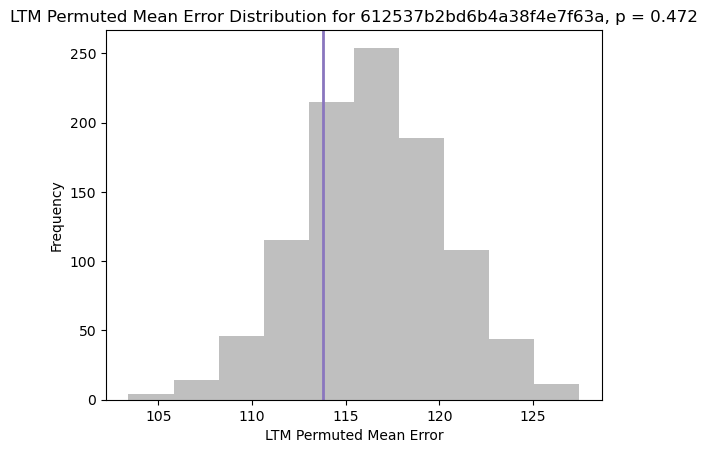

LTM, 6527e40a8a1bf0c1ad98cdd3: p = 0.000
LTM, 5f7f239e9b204e05b6c36538: p = 0.732


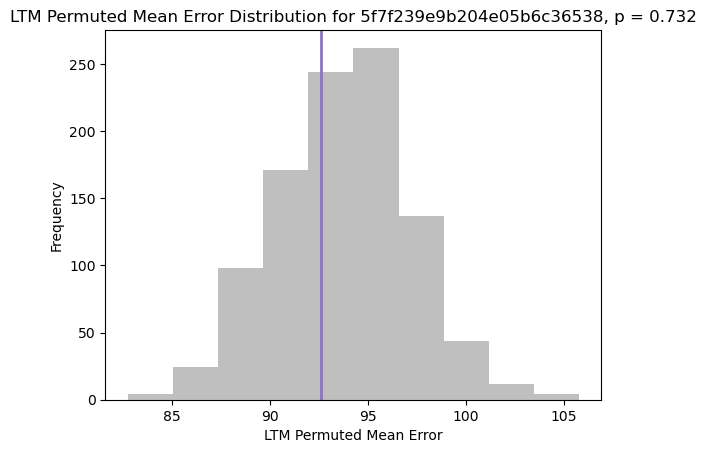

LTM, 60c9f83c9e07879a1ca4ae3a: p = 0.088


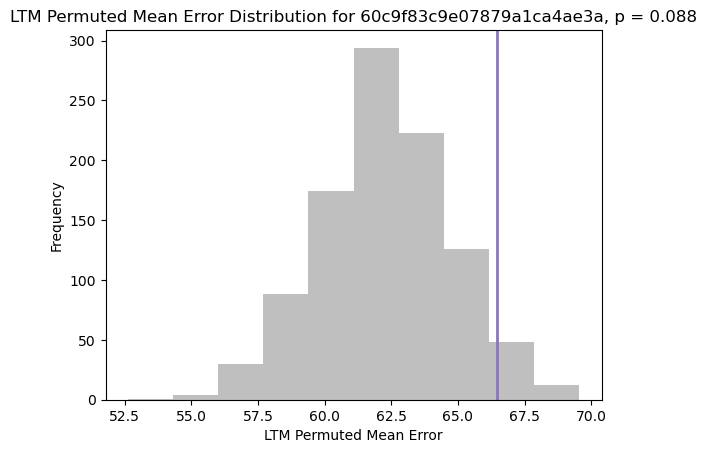

LTM, 5b0c1fdebd9c3100015641ae: p = 0.000
LTM, 609bfd97a7c95881330491d4: p = 0.000
LTM, 605a2dbead400eae8de18f8c: p = 0.428


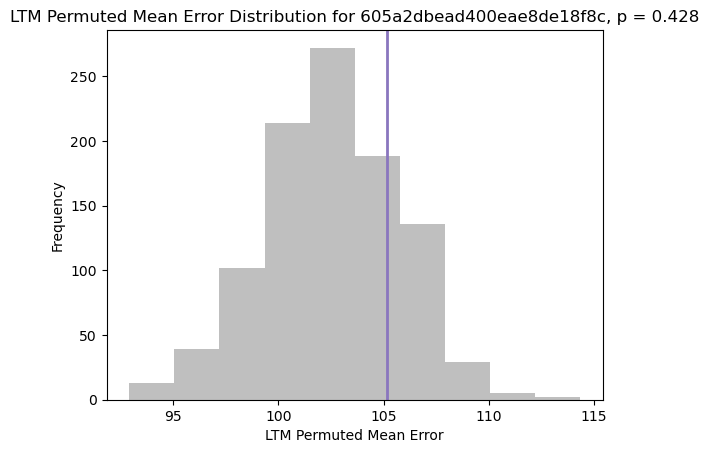

LTM, 5fe3792db939ed02b8c1d0f8: p = 0.000
LTM, 5e8a5a892f6f027054a83d88: p = 0.000
LTM, 656013477ede6fae3cc2728b: p = 0.408


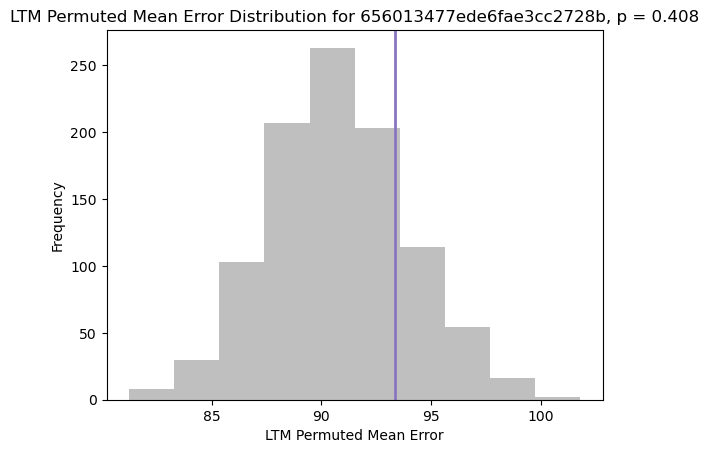

LTM, 60ef2e52a188d9859f92bb58: p = 0.052


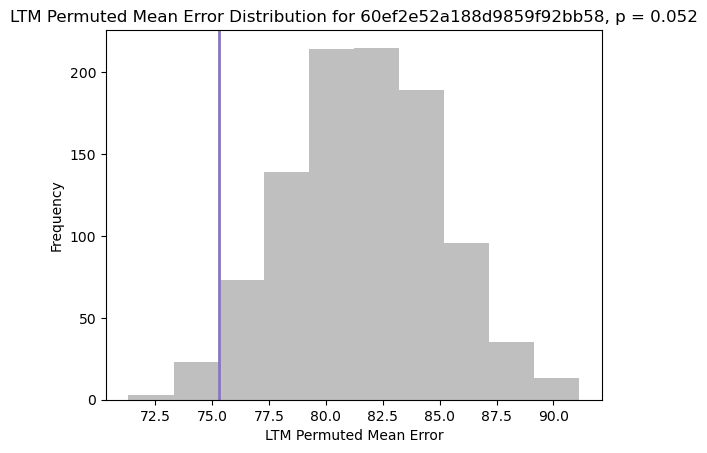

LTM, 654afb2d87012840100daf23: p = 0.000
LTM, 5608a73fd7def20012b7389d: p = 0.000
LTM, 5e1f7b2a4c9b832b34e7c9d3: p = 0.000
LTM, 65c0f99b71fb575465c6ca0d: p = 0.054


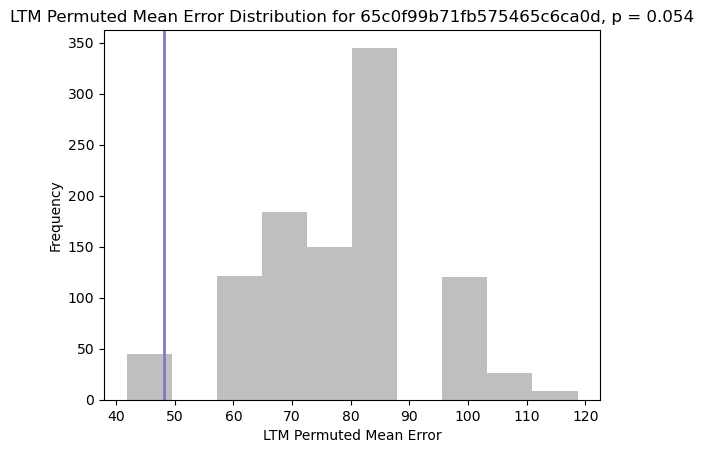

LTM, 65a9346ad1f231c46618a067: p = 0.444


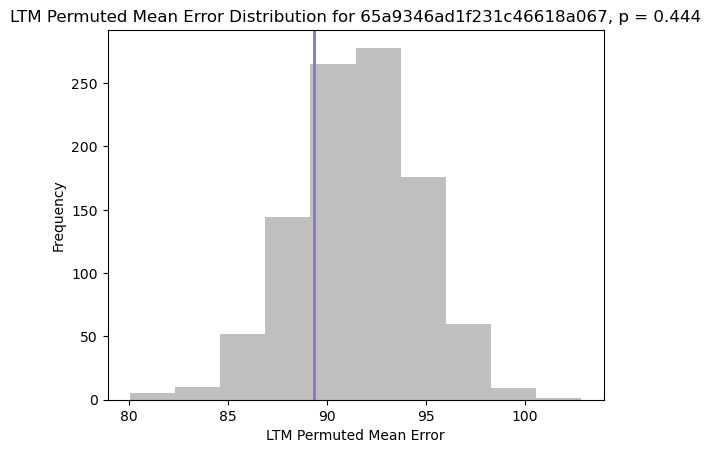

LTM, 65745708518a6ec1b4773387: p = 0.000
LTM, 545d347afdf99b7f9fca22c7: p = 0.000
LTM, 5cc618c53c503e0001a61a63: p = 0.966


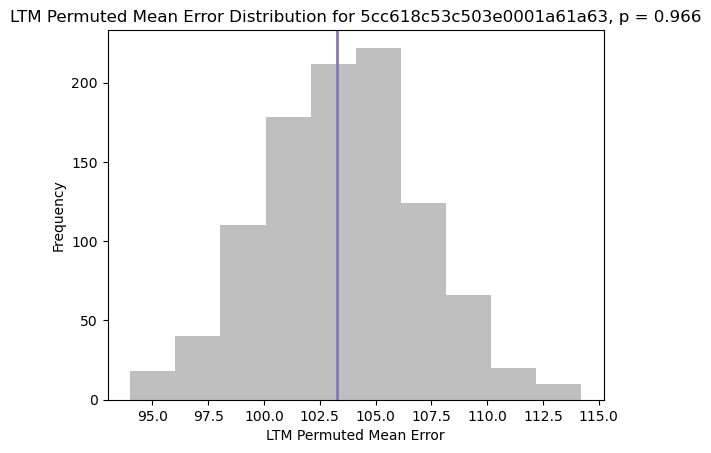

LTM, 561487ad7ffc8a0012812266: p = 0.000
LTM, 5c60c298af517e0001a00b00: p = 0.000
LTM, 607893faf75b80c8b2a14613: p = 0.000
LTM, 657fbbe828dfa7fbd9a169b6: p = 0.000
LTM, 60f679ef8bc07769a1af64e4: p = 0.142


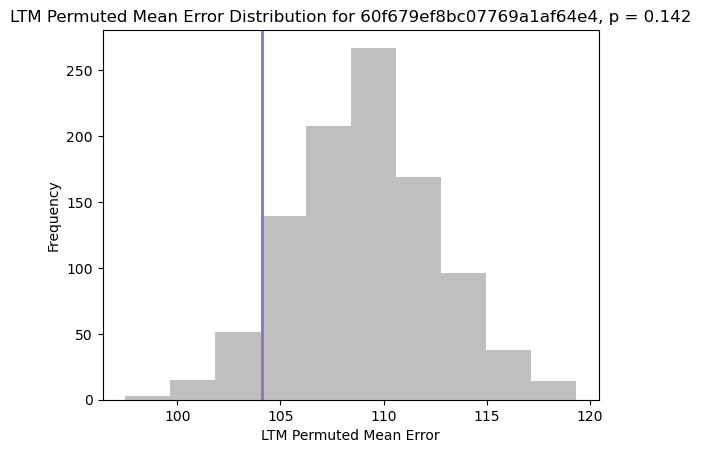

LTM, 63ffcb367b500c516d0648a2: p = 0.370


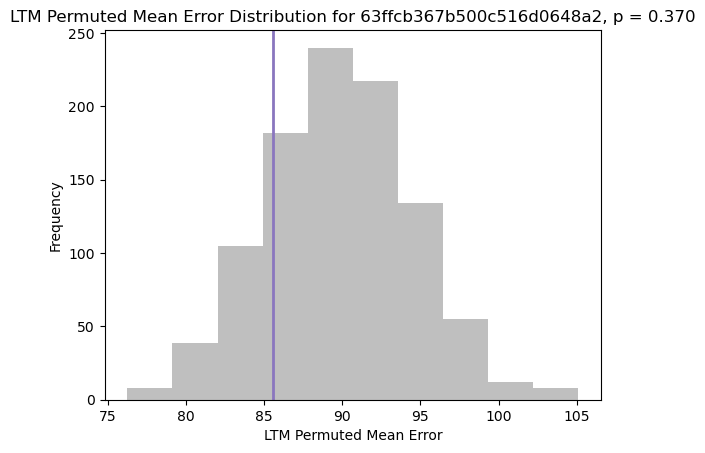

LTM, 650222d04fe305c48c9a98ee: p = 0.284


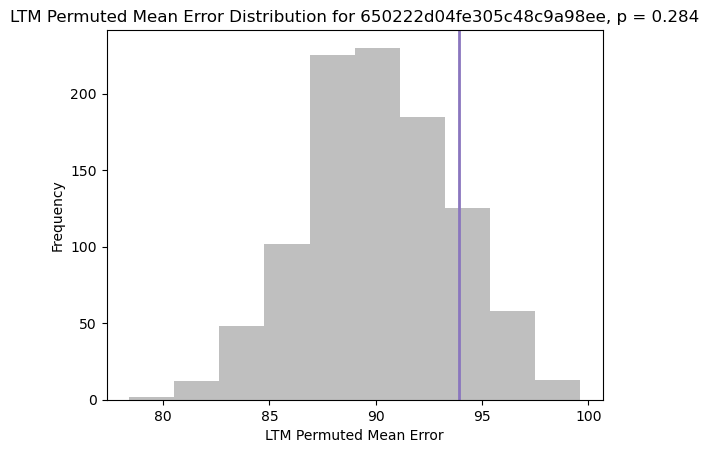

In [ ]:
# for each particpant, we shuffle the response, calculated the errors after shuffling, and then calculate the mean of the errors. We repeat this permutation for 1000 times, and then get the distribution of the mean errors. We compare the real mean error against the permutation distribution to get a p value.
for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    wm_response = participant_data[participant_data['MemoryType'] == 'WM']['selectedShape'].to_numpy()
    wm_truth = participant_data[participant_data['MemoryType'] == 'WM']['shapeTruth'].to_numpy().astype(float)
    wm_permuted_mean_error = []
    for i in range(1000):
        wm_permuted_response = wm_response.copy()
        np.random.shuffle(wm_permuted_response)
        wm_permuted_mean_error.append(np.mean(np.abs(circular_distance(wm_permuted_response, wm_truth))))
    wm_real_mean_error = np.mean(np.abs(circular_distance(wm_response, wm_truth)))
    # Calculate the two-tailed p-value
    greater = np.mean(np.array(wm_permuted_mean_error) > wm_real_mean_error)
    lesser = np.mean(np.array(wm_permuted_mean_error) < wm_real_mean_error)
    wm_p = 2 * min(greater, lesser)  # This accounts for both tails
    print(f'WM, {pid}: p = {wm_p:.3f}')
    if wm_p >= 0.05:
        # plot the histogram of the permuted mean error; add the real mean error to the plot
        plt.hist(wm_permuted_mean_error, bins=10, color='gray', alpha=0.5)
        plt.axvline(x=wm_real_mean_error, color=color_wm, linewidth=2)
        plt.xlabel('WM Permuted Mean Error')
        plt.ylabel('Frequency')
        plt.title(f'WM Permuted Mean Error Distribution for {pid}, p = {wm_p:.3f}')
        plt.show()
    
    

for pid in participant_ids:
    participant_data = all_participants_data[all_participants_data['ParticipantID'] == pid]
    ltm_response = participant_data[participant_data['MemoryType'] == 'LTM']['selectedShape'].to_numpy()
    ltm_truth = participant_data[participant_data['MemoryType'] == 'LTM']['shapeTruth'].to_numpy().astype(float)
    ltm_permuted_mean_error = []
    for i in range(1000):
        ltm_permuted_response = ltm_response.copy()
        np.random.shuffle(ltm_permuted_response)
        ltm_permuted_mean_error.append(np.mean(np.abs(circular_distance(ltm_permuted_response, ltm_truth))))
    ltm_real_mean_error = np.mean(np.abs(circular_distance(ltm_response, ltm_truth)))
    # Calculate the two-tailed p-value
    greater = np.mean(np.array(ltm_permuted_mean_error) > ltm_real_mean_error)
    lesser = np.mean(np.array(ltm_permuted_mean_error) < ltm_real_mean_error)
    ltm_p = 2 * min(greater, lesser)  # This accounts for both tails
    print(f'LTM, {pid}: p = {ltm_p:.3f}')
    if ltm_p >= 0.05:
        # plot the histogram of the permuted mean error; add the real mean error to the plot
        plt.hist(ltm_permuted_mean_error, bins=10, color='gray', alpha=0.5)
        plt.axvline(x=ltm_real_mean_error, color=color_ltm, linewidth=2)
        plt.xlabel('LTM Permuted Mean Error')
        plt.ylabel('Frequency')
        plt.title(f'LTM Permuted Mean Error Distribution for {pid}, p = {ltm_p:.3f}')
        plt.show()



In [ ]:
# For each row of all_participants_data, get the three values in WM_LTM_VALUES different from the `shapeTruth` value, put these three values in a new column nontargets
def find_non_targets(row):
    target = int(row['shapeTruth'])
    non_targets = [value for value in WM_LTM_VALUES if value != target]
    return non_targets
all_participants_data['nontargets'] = all_participants_data.apply(find_non_targets, axis=1)


In [ ]:
ltm_participants_data = all_participants_data[all_participants_data['MemoryType'] == 'LTM']
wm_participants_data = all_participants_data[all_participants_data['MemoryType'] == 'WM']

# define nontarget which is the value (a single value) in row['ltm_shapes'] and row['wm_shapes'] that is not the shapeTruth in this row
def ltm_non_target(row):
    target = int(row['shapeTruth'])
    non_target = [value for value in row['ltm_shapes'] if value != target]
    return non_target[0]

def wm_non_target(row):
    target = int(row['shapeTruth'])
    non_target = [value for value in row['wm_shapes'] if value != target]
    return non_target[0]

ltm_participants_data['nontarget'] = ltm_participants_data.apply(ltm_non_target, axis=1)
wm_participants_data['nontarget'] = wm_participants_data.apply(wm_non_target, axis=1)

# add a column of nontarget_deviation: the circular distance between nontarget and selectedShape
ltm_participants_data['nontarget_deviation'] = circular_distance(ltm_participants_data['nontarget'], ltm_participants_data['selectedShape'].to_numpy().astype(int))
wm_participants_data['nontarget_deviation'] = circular_distance(wm_participants_data['nontarget'], wm_participants_data['selectedShape'].to_numpy().astype(int))



In [ ]:
# run the mixture model for every participant in ltm_participants_data and wm_participants_data
precision_ltm = []
guess_rate_ltm = []
swap_rate_ltm = []
precision_wm = []
guess_rate_wm = []
swap_rate_wm = []
# LTM
for pid in participant_ids:
    participant_data = ltm_participants_data[ltm_participants_data['ParticipantID'] == pid]
    precision, guess_rate, swap_rate = bmt.fit_mixture_model(x=participant_data['rawDeviation'].astype(int),x_nontargets=[participant_data['nontarget_deviation']],include_bias=False)
    print(f'LTM, {pid}: precision = {precision:.3f}, guess_rate = {guess_rate:.3f}, swap_rate = {swap_rate:.3f}')
    precision_ltm.append(precision)
    guess_rate_ltm.append(guess_rate)
    swap_rate_ltm.append(swap_rate)

# WM
for pid in participant_ids:
    participant_data = wm_participants_data[wm_participants_data['ParticipantID'] == pid]
    precision, guess_rate, swap_rate = bmt.fit_mixture_model(x=participant_data['rawDeviation'].astype(int),x_nontargets=[participant_data['nontarget_deviation']],include_bias=False)
    print(f'WM, {pid}: precision = {precision:.3f}, guess_rate = {guess_rate:.3f}, swap_rate = {swap_rate:.3f}')
    precision_wm.append(precision)
    guess_rate_wm.append(guess_rate)
    swap_rate_wm.append(swap_rate)



LTM, 5c8bafb53b6f3d00013d7c30: precision = 124.945, guess_rate = 0.500, swap_rate = 0.121
LTM, 5f21c29511084913913af654: precision = 499.992, guess_rate = 0.262, swap_rate = 0.010
LTM, 5d453e8723a5bb0001492546: precision = 500.000, guess_rate = 0.137, swap_rate = 0.006
LTM, 5f7014ba8655415e9dddc1b7: precision = 205.950, guess_rate = 0.224, swap_rate = 0.000
LTM, 5f06eefaf3fc742667b4e79d: precision = 499.978, guess_rate = 0.500, swap_rate = 0.114
LTM, 651eda4af4a809dbba0bb002: precision = 147.418, guess_rate = 0.029, swap_rate = 0.000
LTM, 658405e29e9aac7350cdb75a: precision = 914.901, guess_rate = 0.236, swap_rate = 0.000
LTM, 60bbc368a316ee5421a1153b: precision = 76.716, guess_rate = 0.150, swap_rate = 0.000
LTM, 5d49d17b3dad1f0001e2aba1: precision = 499.963, guess_rate = 0.500, swap_rate = 0.203
LTM, 5ed8cf4782a6eb04ddf9962d: precision = 363.121, guess_rate = 0.052, swap_rate = 0.047
LTM, 5edab6df83998915303516d5: precision = 618.927, guess_rate = 0.000, swap_rate = 0.000
LTM, 65e2b3

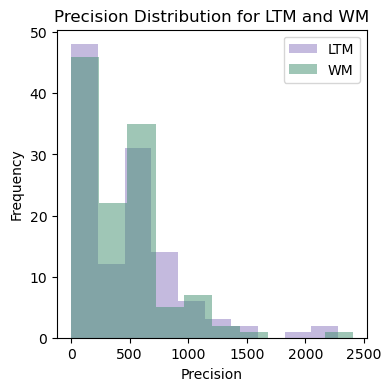

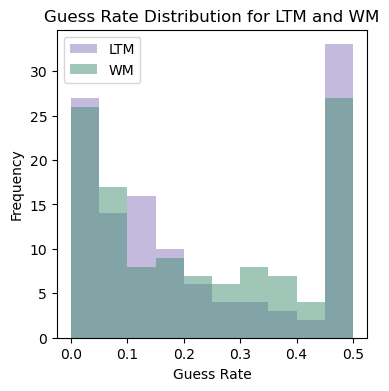

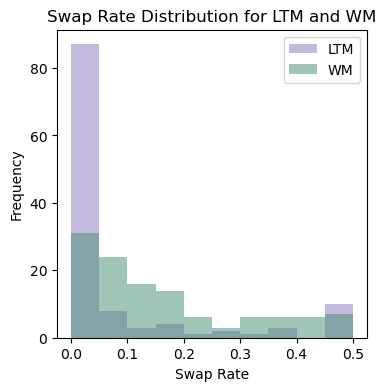

In [ ]:
# for precision, guess_rate, and swap rate, compare the histogram of ltm and wm in the same plot
# precision
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(precision_ltm, bins=10, color=color_ltm, alpha=0.5, label='LTM')
ax.hist(precision_wm, bins=10, color=color_wm, alpha=0.5, label='WM')
ax.set_xlabel('Precision')
ax.set_ylabel('Frequency')
ax.set_title('Precision Distribution for LTM and WM')
plt.legend()
plt.show()

# guess rate
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(guess_rate_ltm, bins=10, color=color_ltm, alpha=0.5, label='LTM')
ax.hist(guess_rate_wm, bins=10, color=color_wm, alpha=0.5, label='WM')
ax.set_xlabel('Guess Rate')
ax.set_ylabel('Frequency')
ax.set_title('Guess Rate Distribution for LTM and WM')
plt.legend()
plt.show()

# swap rate
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(swap_rate_ltm, bins=10, color=color_ltm, alpha=0.5, label='LTM')
ax.hist(swap_rate_wm, bins=10, color=color_wm, alpha=0.5, label='WM')
ax.set_xlabel('Swap Rate')
ax.set_ylabel('Frequency')
ax.set_title('Swap Rate Distribution for LTM and WM')
plt.legend()
plt.show()


In [ ]:
# perform t-test for the three rates
t, p = stats.ttest_rel(precision_ltm, precision_wm)
print(f'Precision: t = {t:.3f}, p = {p:.3f}')
t, p = stats.ttest_rel(guess_rate_ltm, guess_rate_wm)
print(f'Guess Rate: t = {t:.3f}, p = {p:.3f}')
t, p = stats.ttest_rel(swap_rate_ltm, swap_rate_wm)
print(f'Swap Rate: t = {t:.3f}, p = {p:.3f}')
mean_ltm_swap_rate = np.mean(swap_rate_ltm)
mean_wm_swap_rate = np.mean(swap_rate_wm)
print(f'Mean LTM Swap Rate: {mean_ltm_swap_rate:.3f}')
print(f'Mean WM Swap Rate: {mean_wm_swap_rate:.3f}')



Precision: t = 1.163, p = 0.247
Guess Rate: t = 0.009, p = 0.993
Swap Rate: t = -4.226, p = 0.000
Mean LTM Swap Rate: 0.078
Mean WM Swap Rate: 0.160


In [ ]:
# TO-DO
# check if ltm_data is normally distributed
# exlude people whose performance is outside of three standard deviations from the group mean.


In [ ]:
# comparing the overall level of LTM errors using data from ltm_deviation.csv and ltm_deviation_exp3.csv
# first read the data from ltm_deviation.csv, and ltm_deviation_exp3.csv
ltm_deviation = pd.read_csv('ltm_deviation.csv')
ltm_deviation_exp3 = pd.read_csv('../ltm_deviation_exp3.csv')
# conduct a t-test to compare the two groups
t, p = stats.ttest_ind(ltm_deviation['deviation'], ltm_deviation_exp3['value'], equal_var=False)
print(f'LTM Deviation: t = {t:.3f}, p = {p:.3f}')
# determine the degrees of freedom for the t-test: \[ df = \frac{{(s1^2/n1 + s2^2/n2)^2}}{{(s1^2/n1)^2/(n1-1) + (s2^2/n2)^2/(n2-1)}} \] 
# df = (ltm_deviation['deviation'].std()**2/len(ltm_deviation) + ltm_deviation_exp3['value'].std()**2/len(ltm_deviation_exp3))**2 / ((ltm_deviation['deviation'].std()**2/len(ltm_deviation))**2/(len(ltm_deviation)-1) + (ltm_deviation_exp3['value'].std()**2/len(ltm_deviation_exp3))**2/(len(ltm_deviation_exp3)-1))
# print(f'Degrees of Freedom: {df}')
# calculate the mean and standard error of the two groups
mean_ltm_deviation = ltm_deviation['deviation'].mean()
se_ltm_deviation = ltm_deviation['deviation'].std()/np.sqrt(len(ltm_deviation))
mean_ltm_deviation_exp3 = ltm_deviation_exp3['value'].mean()
se_ltm_deviation_exp3 = ltm_deviation_exp3['value'].std()/np.sqrt(len(ltm_deviation_exp3))
# print(f'Mean LTM Deviation: {mean_ltm_deviation:.3f} ± {se_ltm_deviation:.3f}')
# print(f'Mean LTM Deviation Exp3: {mean_ltm_deviation_exp3:.3f} ± {se_ltm_deviation_exp3:.3f}')

LTM Deviation: t = 10.031, p = 0.000


In [ ]:
# import package
from scipy.stats import levene

levene(ltm_deviation['deviation'], ltm_deviation_exp3['value'])

LeveneResult(statistic=36.71969050475189, pvalue=9.330385498417746e-09)

In [ ]:
ltm_deviation_exp3['value']

0     18.591667
1     13.084174
2      6.574074
3     10.432738
4     23.963983
5     13.020378
6      9.316682
7     16.937500
8     12.007726
9     13.866667
10    16.843145
11    10.289916
12     8.679622
13    48.022446
14     8.310137
15    15.283022
16     7.424957
17    18.584291
18    20.746875
19    16.410871
20    11.638655
21    14.905266
22     5.246723
23    17.320621
24    17.628571
25    41.442385
26    14.000840
27    18.229167
28    23.747043
29    13.036782
30     9.497446
31    12.100000
32    19.311765
33    16.711667
34    22.087879
35     7.940678
36    15.575047
37     9.266667
38    73.520675
39    16.045833
40    32.137510
41    19.409868
42     5.166558
43    20.276679
Name: value, dtype: float64

In [ ]:
# overall outlier rate: combine memory_task_data and percept_task_data, and calculate the outlier rate
# combine the two dataframes
both_tasks_data = pd.concat([memory_task_data, percept_task_data])
# calculate the outlier rate
outlier_rates = both_tasks_data.groupby('ParticipantID')['outlier'].mean()
# Calculate the average rate and standard deviation of outlier trials across all participants
mean_outlier_rate = outlier_rates.mean()
std_outlier_rate = outlier_rates.std()
print(f'Mean outlier rate: {mean_outlier_rate:.4f} ± {std_outlier_rate:.4f}')

Mean outlier rate: 0.0135 ± 0.0061
